# **Project Title**  
### **Web Scraping and Exploratory Data Analysis (EDA) on EPL for 2023/2024 Season**  

## **Project Overview**  
The goal of this project is to scrape match stats and shooting stats for the 20 English Premier League (EPL) clubs during the 2023/2024 season from <a href="https://fbref.com" target="_blank">fbref.com</a>. After scraping the data, the task is to merge the two datasets (match & shooting)  of all clubs into a single DataFrame and perform Exploratory Data Analysis (EDA) to uncover insights and visualize trends in the data.
  

## **Problem Statement**  
Football is an unpredictable sport, but data-driven analysis can uncover patterns and insights that help in understanding team performance, referee influence, and match dynamics. This project aims to analyze key football metrics, offering insights into team efficiency, defensive solidity, and referee impact.  

Our analysis is centered around answering critical questions such as:  

- **Championship Contender?** Which teams exhibit the strongest performance indicators that suggest they are title contenders?  
- **Shots per Game:** Which team has the highest average shots per game?
- **Expected Goals vs. Actual Goals:** How well do teams convert their expected goals (xG) into actual goals? Are there teams overperforming or underperforming in front of goal?  
- **Goals Scored vs. Goals Conceded per Team:** Which teams balance attacking prowess with defensive stability, and which ones struggle in either aspect?  
- **Shots on Target vs. Total Shots:** Do teams with more total shots also register more shots on target, or do inefficiencies exist?  
- **Average Shots per Game:** Which team generates the most attacking threat by averaging the highest number of shots per match?  
- **Team Formation Analysis:** What are the most common formations used by teams, and how do these formations correlate with success?  
- **Penalty Kick Analysis:** What percentage of penalty kicks are converted across teams?
- **Referee Influence:** How does referee appointment impact match outcomes in terms of goals scored and game dynamics?  
- **Correlation Matrix of Key Metrics:** What are the relationships between crucial football statistics (e.g., possession, shots, goals, and defensive actions)?  
- **Match Attendance Analysis:** Which team attracted highest/lowest spectators?
- **Goals Scored Over the Season (Monthly Trend):** How do teams’ goal-scoring patterns change over time? Do they improve or decline as the season progresses?  

By answering these questions, this project provides a comprehensive data-driven approach to understanding football trends, performance efficiency, and the influence of various match factors.  


# <b>PART ONE</b> --- Web Scraping

In [2]:
import requests, pandas as pd
import time, random
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [88]:
url = 'https://fbref.com/en/comps/9/2023-2024/2023-2024-Premier-League-Stats'
data  = requests.get(url).text
soup = BeautifulSoup(data, 'lxml')

In [89]:
table = soup.select('table', class_="stats_table sortable min_width")[2]

a_tags = table.select('a')

links = [l.get('href') for l in a_tags]
full_url = [f"https://fbref.com{l}" for l in links]

In [90]:
# Convert the URLs
match_urls = []
shooting_urls = []
for url in full_url:
    parts = url.split("/")
    team_id = parts[5]  # Extracts the unique team ID (e.g., 822bd0ba for Liverpool)
    season = parts[6]  # Extracts the season (e.g., 2023-2024)
    
    # Extract team name from the last part and format it properly
    team_name = parts[-1].replace("-Stats", "").replace("-", " ")
    team_name_url = parts[-1].replace("-Stats", "-Scores-and-Fixtures-Premier-League")
    
    # Construct the new URL
    matches = f"https://fbref.com/en/squads/{team_id}/{season}/matchlogs/c9/schedule/{team_name_url}"
    shootings = f"https://fbref.com/en/squads/{team_id}/{season}/matchlogs/c9/shooting/{team_name_url}"

    match_urls.append(matches)
    shooting_urls.append(shootings)


In [91]:
# Function to scrape table data for shootings stats from a given URL
def scrape_table(url, stat_type="matches"):
    """
    This function scrapes for match and shooting stats from 'fbref.com'
    """
    time.sleep(random.uniform(2, 5))  # Delay between 2 to 5 seconds randomly before making the request

    response = requests.get(url)  # Make an HTTP request
    if response.status_code != 200:
        print(f"Failed to retrieve {url}")
        return None  # Return None if request fails

    soup = BeautifulSoup(response.text, "html.parser")  # Parse HTML
    table = soup.find("table", class_="stats_table sortable min_width")  # Find table

    if table is None:
        print(f"No table found in {url}")
        return None

    # Extract column headers
    headers = soup.find("th", scope = "col")
    headers = [th.text.strip() for th in table.find_all("th")]
    
    # Modify headers for shooting stats
    if stat_type == "shooting":
        headers = headers[4:]  # Slice headers for shooting stats


    # Extract the years
    year_date = [th.text.strip() for th in table.find_all("th", scope = "row")]
        
    # Extract table rows
    data = []
    for row in table.find_all("tr")[1:]:  # Skip header rows
        cols = [td.text.strip() for td in row.find_all("td")]
        if cols:  # Only add non-empty rows
            data.append(cols)

    # Create DataFrame
    df = pd.DataFrame(data, columns=headers[:len(data[0])])  # Match column count
    df = df.dropna(axis=1, how="all")  # Remove empty columns
    df = df.shift(axis=1, periods=1)  # Shift columns right
    df['Date'] = year_date
    return df

In [92]:
# Scrape all match URLs and append results
all_match_data = []
for url in match_urls:
    df = scrape_table(url, stat_type="matches")  # Default is match stats
    if df is not None:
        df["Team"] = url.split("/")[-1].replace("-Scores-and-Fixtures-Premier-League", "")  # Add team name column
        all_match_data.append(df)

    
    time.sleep(random.uniform(2, 5))  # Wait between 2 to 5 seconds randomly


# Combine all match data into a single DataFrame
matches_df = pd.concat(all_match_data, ignore_index=True)


# Scrape all shooting URLs and append results
all_shooting_data = []
for url in shooting_urls:
    df = scrape_table(url, stat_type="shooting")    # Scrape shooting stats
    if df is not None:
        df["Team"] = url.split("/")[-1].replace("-Scores-and-Fixtures-Premier-League", "")  # Add team name column
        df = df.iloc[:-1] #exclude the last row
        all_shooting_data.append(df)

    
    time.sleep(random.uniform(2, 5))  # Wait between 2 to 5 seconds randomly


# Combine all shooting data into a single DataFrame
shooting_df = pd.concat(all_shooting_data, ignore_index=True)

In [93]:
shooting_df.to_csv("shooting.csv", index=False)
matches_df.to_csv("match.csv", index= False)

In [102]:
# Merge matches_df and shooting_df on common columns
final_df = pd.merge(matches_df, shooting_df, on=['Date','Time', 'Round', 'Day', 'Venue', 'Result', 'GF', 'GA', 
                                                   'Opponent', 'xG', 'Team'], how='inner')

# Cleaning the Columns names
final_df.columns = final_df.columns.str.replace('_x|_y', '', regex=True)

# Adding Competiton coloum
final_df["Comp"] = "Premier League"
final_df["Season"] = "2023-2024"

# Getting the required coloums
required_final_df = final_df[['Date', 'Time', 'Comp', 'Round', 'Day', 'Venue', 'Result', 'GF', 'GA',
       'Opponent', 'xG', 'xGA', 'Poss', 'Attendance', 'Captain', 'Formation',
       'Referee', 'Match Report', 'Sh', 'SoT', 'Dist', 'FK', 'PK', 'PKatt', 'Season', 'Team']]

# Renaming Abrreviated Columns names for easy Visualiastion

column_renames = {
    'Date': 'Match_Date',
    'Time': 'Match_Time',
    'Comp': 'Competition',
    'Round': 'Match_Round',
    'Day': 'Match_Day',
    'Venue': 'Stadium_Venue',
    'Result': 'Match_Result',
    'GF': 'Goals_For',
    'GA': 'Goals_Against',
    'Opponent': 'Opponent_Team',
    'xG': 'Expected_Goals',
    'xGA': 'Expected_Goals_Against',
    'Poss': 'Possession',
    'Attendance': 'Match_Attendance',
    'Captain': 'Team_Captain',
    'Formation': 'Team_Formation',
    'Referee': 'Match_Referee',
    'Match Report': 'Match_Report_URL',
    'Sh': 'Total_Shots',
    'SoT': 'Shots_On_Target',
    'Dist': 'Shot_Distance_Avg',
    'FK': 'Free_Kicks_Taken',
    'PK': 'Penalty_Kicks_Scored',
    'PKatt': 'Penalty_Attempts'
}


# Rename columns
required_final_df = required_final_df.copy()
required_final_df.rename(columns=column_renames, inplace=True)
# Removing Duplicate Columns

required_final_df = required_final_df.loc[:, ~required_final_df.columns.duplicated()]

required_final_df['Team_Formation'] = required_final_df['Team_Formation'].str.replace('-', '_')

# Display the DataFrame
required_final_df

,Match_Date,Match_Time,Competition,Match_Round,Match_Day,Stadium_Venue,Match_Result,Goals_For,Goals_Against,Opponent_Team,...,Match_Referee,Match_Report_URL,Total_Shots,Shots_On_Target,Shot_Distance_Avg,Free_Kicks_Taken,Penalty_Kicks_Scored,Penalty_Attempts,Season,Team
0,2023-08-12,12:30,Premier League,Matchweek 1,Sat,Home,W,2,1,Nott'ham Forest,...,Michael Oliver,Match Report,15,7,19.1,0,0,0,2023-2024,Arsenal
1,2023-08-21,20:00,Premier League,Matchweek 2,Mon,Away,W,1,0,Crystal Palace,...,David Coote,Match Report,13,2,16.4,0,1,1,2023-2024,Arsenal
2,2023-08-26,15:00,Premier League,Matchweek 3,Sat,Home,D,2,2,Fulham,...,Paul Tierney,Match Report,18,9,13.8,0,1,1,2023-2024,Arsenal
3,2023-09-03,16:30,Premier League,Matchweek 4,Sun,Home,W,3,1,Manchester Utd,...,Anthony Taylor,Match Report,17,5,15.0,0,0,0,2023-2024,Arsenal
4,2023-09-17,16:30,Premier League,Matchweek 5,Sun,Away,W,1,0,Everton,...,Simon Hooper,Match Report,13,4,17.4,0,0,0,2023-2024,Arsenal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,2024-04-24,19:45,Premier League,Matchweek 29,Wed,Home,L,0,1,Bournemouth,...,Stuart Attwell,Match Report,15,4,20.1,0,0,0,2023-2024,Wolverhampton-Wanderers
756,2024-04-27,15:00,Premier League,Matchweek 35,Sat,Home,W,2,1,Luton Town,...,David Coote,Match Report,13,5,18.8,0,0,0,2023-2024,Wolverhampton-Wanderers
757,2024-05-04,17:30,Premier League,Matchweek 36,Sat,Away,L,1,5,Manchester City,...,Craig Pawson,Match Report,2,1,9.0,0,0,0,2023-2024,Wolverhampton-Wanderers
758,2024-05-11,15:00,Premier League,Matchweek 37,Sat,Home,L,1,3,Crystal Palace,...,Thomas Bramall,Match Report,14,8,14.6,0,0,0,2023-2024,Wolverhampton-Wanderers


In [98]:
# Save to CSV 
required_final_df.to_csv("my_fbress_combined_required_data.csv", index=False)

# <b>PART TWO</b> --- Data Preparation

In [3]:
# Load the CSV file
file_path = "my_fbress_combined_required_data.csv"
df = pd.read_csv(file_path)

# Get basic information about the dataset
df_info = df.info()
df_head = df.head()
df_summary = df.describe(include="all")  # Summary statistics

# Check for missing values and duplicates
missing_values = df.isnull().sum()
duplicates = df.duplicated().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Match_Date              760 non-null    object 
 1   Match_Time              760 non-null    object 
 2   Competition             760 non-null    object 
 3   Match_Round             760 non-null    object 
 4   Match_Day               760 non-null    object 
 5   Stadium_Venue           760 non-null    object 
 6   Match_Result            760 non-null    object 
 7   Goals_For               760 non-null    int64  
 8   Goals_Against           760 non-null    int64  
 9   Opponent_Team           760 non-null    object 
 10  Expected_Goals          760 non-null    float64
 11  Expected_Goals_Against  760 non-null    float64
 12  Possession              760 non-null    int64  
 13  Match_Attendance        760 non-null    object 
 14  Team_Captain            760 non-null    ob

In [104]:
df_summary

,Match_Date,Match_Time,Competition,Match_Round,Match_Day,Stadium_Venue,Match_Result,Goals_For,Goals_Against,Opponent_Team,...,Match_Referee,Match_Report_URL,Total_Shots,Shots_On_Target,Shot_Distance_Avg,Free_Kicks_Taken,Penalty_Kicks_Scored,Penalty_Attempts,Season,Team
count,760,760,760,760,760,760,760,760.000000,760.000000,760,...,760,760,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760,760
unique,120,15,1,38,7,2,3,NaN,NaN,20,...,28,1,NaN,NaN,NaN,NaN,NaN,NaN,1,20
top,2024-05-19,15:00,Premier League,Matchweek 1,Sat,Home,W,NaN,NaN,Nott'ham Forest,...,Anthony Taylor,Match Report,NaN,NaN,NaN,NaN,NaN,NaN,2023-2024,Arsenal
freq,20,264,760,20,390,380,298,NaN,NaN,38,...,54,760,NaN,NaN,NaN,NaN,NaN,NaN,760,38
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.639474,1.639474,NaN,...,NaN,NaN,13.660526,4.668421,16.711974,0.372368,0.126316,0.140789,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.331297,1.331297,NaN,...,NaN,NaN,6.058391,2.645612,2.856226,0.598218,0.359097,0.377104,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,...,NaN,NaN,1.000000,0.000000,7.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,NaN,...,NaN,NaN,9.000000,3.000000,14.900000,0.000000,0.000000,0.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,NaN,...,NaN,NaN,13.000000,4.000000,16.700000,0.000000,0.000000,0.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,2.000000,NaN,...,NaN,NaN,17.000000,6.000000,18.400000,1.000000,0.000000,0.000000,NaN,NaN


In [105]:
df_head

,Match_Date,Match_Time,Competition,Match_Round,Match_Day,Stadium_Venue,Match_Result,Goals_For,Goals_Against,Opponent_Team,...,Match_Referee,Match_Report_URL,Total_Shots,Shots_On_Target,Shot_Distance_Avg,Free_Kicks_Taken,Penalty_Kicks_Scored,Penalty_Attempts,Season,Team
0,2023-08-12,12:30,Premier League,Matchweek 1,Sat,Home,W,2,1,Nott'ham Forest,...,Michael Oliver,Match Report,15,7,19.1,0,0,0,2023-2024,Arsenal
1,2023-08-21,20:00,Premier League,Matchweek 2,Mon,Away,W,1,0,Crystal Palace,...,David Coote,Match Report,13,2,16.4,0,1,1,2023-2024,Arsenal
2,2023-08-26,15:00,Premier League,Matchweek 3,Sat,Home,D,2,2,Fulham,...,Paul Tierney,Match Report,18,9,13.8,0,1,1,2023-2024,Arsenal
3,2023-09-03,16:30,Premier League,Matchweek 4,Sun,Home,W,3,1,Manchester Utd,...,Anthony Taylor,Match Report,17,5,15.0,0,0,0,2023-2024,Arsenal
4,2023-09-17,16:30,Premier League,Matchweek 5,Sun,Away,W,1,0,Everton,...,Simon Hooper,Match Report,13,4,17.4,0,0,0,2023-2024,Arsenal


In [106]:
print(missing_values)


Match_Date                0
Match_Time                0
Competition               0
Match_Round               0
Match_Day                 0
Stadium_Venue             0
Match_Result              0
Goals_For                 0
Goals_Against             0
Opponent_Team             0
Expected_Goals            0
Expected_Goals_Against    0
Possession                0
Match_Attendance          0
Team_Captain              0
Team_Formation            0
Match_Referee             0
Match_Report_URL          0
Total_Shots               0
Shots_On_Target           0
Shot_Distance_Avg         0
Free_Kicks_Taken          0
Penalty_Kicks_Scored      0
Penalty_Attempts          0
Season                    0
Team                      0
dtype: int64


In [107]:
# Convert relevant columns to numeric
columns_to_numeric = ["Match_Attendance"]
for col in columns_to_numeric:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Re-check data types after conversion
df.dtypes


Match_Date                 object
Match_Time                 object
Competition                object
Match_Round                object
Match_Day                  object
Stadium_Venue              object
Match_Result               object
Goals_For                   int64
Goals_Against               int64
Opponent_Team              object
Expected_Goals            float64
Expected_Goals_Against    float64
Possession                  int64
Match_Attendance          float64
Team_Captain               object
Team_Formation             object
Match_Referee              object
Match_Report_URL           object
Total_Shots                 int64
Shots_On_Target             int64
Shot_Distance_Avg         float64
Free_Kicks_Taken            int64
Penalty_Kicks_Scored        int64
Penalty_Attempts            int64
Season                     object
Team                       object
dtype: object

In [108]:
# Check unique stadium names
unique_stadiums = df["Stadium_Venue"].unique()

# Identify how many times each stadium appears
stadium_counts = df["Stadium_Venue"].value_counts()

In [109]:
print(unique_stadiums)

['Home' 'Away']


In [110]:
print(stadium_counts)

Stadium_Venue
Home    380
Away    380
Name: count, dtype: int64


# <b>PART THREE</b> --- Exploratory Data Analysis (EDA)

#### Analysis on Goals Scored vs. Goals Conceded per Team

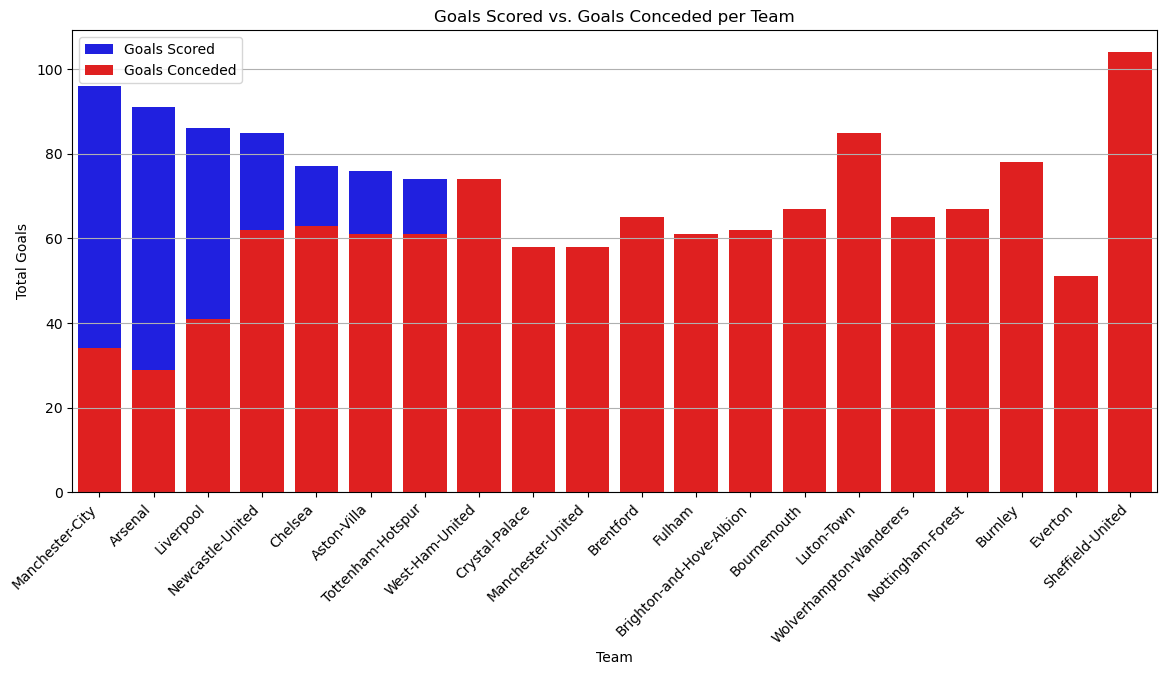

In [29]:
# Aggregate total goals scored and conceded per team
team_goal_stats = df.groupby("Team").agg({"Goals_For": "sum", "Goals_Against": "sum"}).reset_index()

# Calculate goal difference
team_goal_stats["Goal_Difference"] = team_goal_stats["Goals_For"] - team_goal_stats["Goals_Against"]

# Sort teams by Goals_For for better visualization
team_goal_stats = team_goal_stats.sort_values(by="Goals_For", ascending=False)

# Plot Goals Scored vs. Goals Conceded per team
plt.figure(figsize=(14, 6))
sns.barplot(x="Team", y="Goals_For", data=team_goal_stats, color="blue", label="Goals Scored")
sns.barplot(x="Team", y="Goals_Against", data=team_goal_stats, color="red", label="Goals Conceded")

# Formatting
plt.xticks(rotation=45, ha="right")
plt.title("Goals Scored vs. Goals Conceded per Team")
plt.xlabel("Team")
plt.ylabel("Total Goals")
plt.legend()
plt.grid(axis="y")

# Show plot
plt.show()


<h4>Detailed Analysis of the First Two and Last Two Teams</h4>

# Team Performance Table

| Team              | Goals Scored (For) | Goals Conceded (Against) | Goal Difference |
|------------------|------------------|------------------------|----------------|
| Manchester City  | 96               | 34                     | +62           |
| Arsenal         | 91               | 29                     | +62           |
| Everton        | 40               | 51                     | -11           |
| Sheffield United | 35               | 104                    | -69           |


1. <b>Manchester City & Arsenal (First Two Teams)</b>

Blue bars (Goals_For) are very high, reaching up to 96 and 91 on the Y-axis.<br>
Red bars (Goals_Against) are much lower, meaning they conceded far fewer goals (34 and 29).<br>
Their Goal Difference is +62, showing they dominated most matches.<br>
They likely finished at the top of the league.

2. <b>Everton & Sheffield United (Last Two Teams)</b>

Blue bars (Goals_For) are much shorter, indicating low-scoring teams (40 and 35 goals).<br>
Red bars (Goals_Against) are much taller, especially for Sheffield United, who conceded 104 goals!<br>
Negative Goal Difference (-11 for Everton, -69 for Sheffield) means they lost more games than they won.<br>
Sheffield United's red bar is extremely tall, showing a very weak defense and likely a relegation battle.

<b>Key Insights from the Y-Axis Representation of the bar plot</b>

Teams at the top (Man City & Arsenal) have blue bars much higher than red bars → Successful season.<br>
Teams at the bottom (Everton & Sheffield United) have red bars much higher than blue bars → Struggling season.<br>
The bigger the gap between blue and red, the stronger or weaker the team’s season.

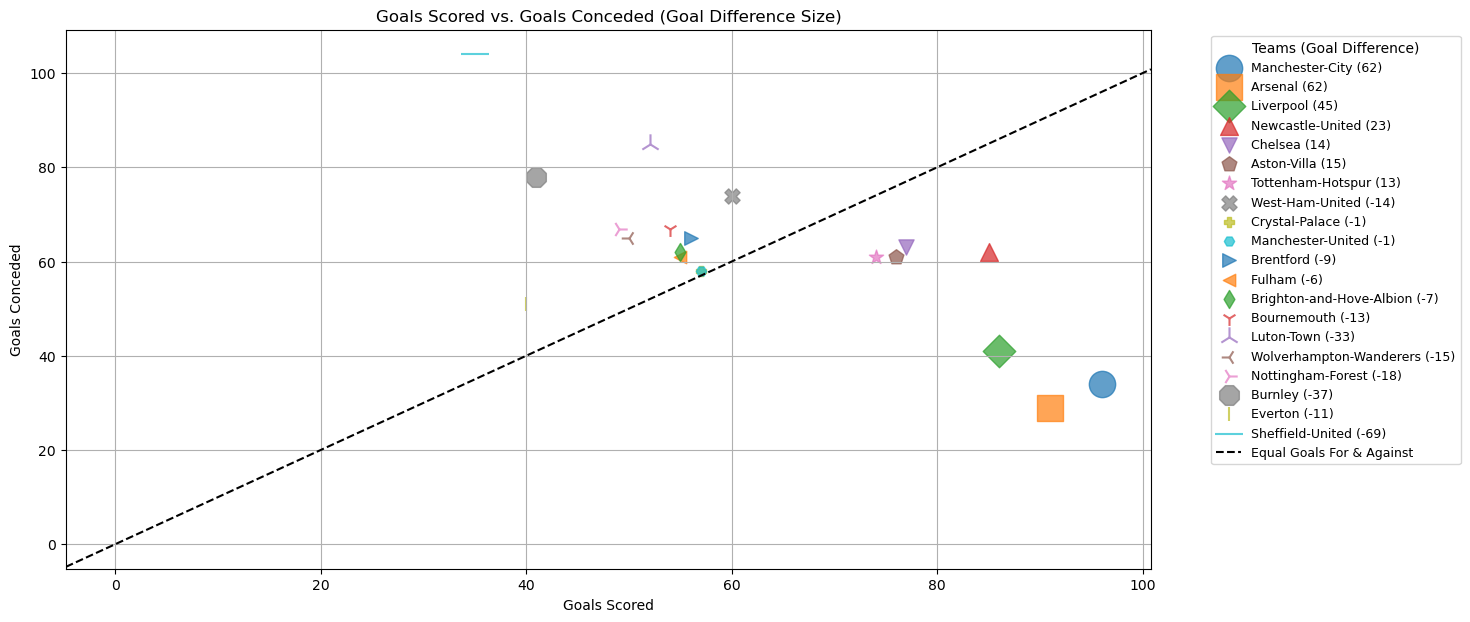

In [31]:
# Scatter plot for further analysis
# # Define marker styles for teams
team_markers = ['o', 's', 'D', '^', 'v', 'p', '*', 'X', 'P', 'H', '>', '<', 'd', '1', '2', '3', '4', '8', '|', '_']

# Set figure size
plt.figure(figsize=(14, 7))

# Create scatter plot with team-specific markers
for (team, goals_for, goals_against, goal_diff, marker) in zip(
        team_goal_stats["Team"], team_goal_stats["Goals_For"],
        team_goal_stats["Goals_Against"], team_goal_stats["Goal_Difference"], team_markers):
    plt.scatter(goals_for, goals_against, s=abs(goal_diff) * 5 + 50, 
                label=f"{team} ({goal_diff})", marker=marker, alpha=0.7)

# Formatting
plt.title("Goals Scored vs. Goals Conceded (Goal Difference Size)")
plt.xlabel("Goals Scored")
plt.ylabel("Goals Conceded")
plt.axline((0, 0), slope=1, linestyle="dashed", color="black", label="Equal Goals For & Against")

# Move legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Teams (Goal Difference)", fontsize=9)
plt.grid()

# Show plot
plt.show()


### **Key Insights from the Scatter Plot**

#### **1. Teams with the Best Performance (Bottom Right, Large Markers)**
- **Manchester City, Arsenal, and Liverpool** have high **Goals Scored** and relatively low **Goals Conceded**.
- Their large marker sizes indicate a strong **positive Goal Difference**.
- They are well-separated from teams with negative goal differences.

#### **2. Teams with Balanced Performance (Middle Region)**
- **Newcastle United, Chelsea, Aston Villa, and Tottenham Hotspur** have moderate goal differences.
- They are scoring and conceding goals at a closer rate, leading to medium-sized markers.
- These teams could be classified as **competitive but inconsistent**.

#### **3. Teams Struggling with Goal Difference (Top Left, Small Markers)**
- **Luton Town, Nottingham Forest, Burnley, and Sheffield United** have the worst goal differences.
- **Sheffield United** stands out with the **worst goal difference (-69)**, as seen in the very small marker size.
- These teams are conceding **far more goals than they score**, which is a major concern.

#### **4. Teams Near the Equal Goals Line (Dotted Line)**
- **Crystal Palace and Manchester United** have a **goal difference close to zero**, meaning they score and concede at nearly the same rate.
- These teams are in a delicate position; a small change in form could push them into **positive or negative territory**.

#### **5. Defensive vs. Attacking Strengths**
- **Manchester City, Arsenal, and Liverpool** not only have the best goal differences but also **concede fewer goals** compared to most teams.
- **West Ham, Luton Town, and Sheffield United** concede the most goals, indicating **defensive struggles**.

#### **6. High Scoring but Weak Defensively**
- Some teams like **Chelsea and Newcastle United** are positioned relatively high in both goals scored and goals conceded.
- This suggests they have **strong attacking** but also **leaky defenses**.

### **Overall Takeaways**
✅ **Title Challengers** → Manchester City, Arsenal, Liverpool (high goals, low conceded, strong goal difference).  
✅ **European Contenders** → Newcastle, Chelsea, Aston Villa, Tottenham (good attacking sides but need defensive improvements).  
⚠️ **Relegation Threatened** → Sheffield United, Burnley, Luton Town, Nottingham Forest (low scoring, high conceding, poor goal difference).  
⚖️ **Mid-Table Mediocrity** → Manchester United, Crystal Palace, Brentford (balanced but not dominant).  


ANALYSIS ON HOME VS AWAY PERFORMANCE

In [130]:
# Count the number of wins for each team in home and away matches
team_wins = df.copy()

# Define wins based on Goals_For > Goals_Against
team_wins["Win"] = team_wins["Goals_For"] > team_wins["Goals_Against"]

# Count wins for each team in Home and Away matches
home_wins = team_wins[team_wins["Stadium_Venue"] == "Home"].groupby("Team")["Win"].sum().reset_index()
away_wins = team_wins[team_wins["Stadium_Venue"] == "Away"].groupby("Team")["Win"].sum().reset_index()

# Rename columns for clarity
home_wins.columns = ["Team", "Home_Wins"]
away_wins.columns = ["Team", "Away_Wins"]

# Merge both datasets
team_wins_summary = pd.merge(home_wins, away_wins, on="Team")

# Find teams with most home and away wins
most_home_wins_team = team_wins_summary.loc[team_wins_summary["Home_Wins"].idxmax()]
most_away_wins_team = team_wins_summary.loc[team_wins_summary["Away_Wins"].idxmax()]

# Display results
team_wins_summary.sort_values(by=["Home_Wins", "Away_Wins"], ascending=False)


,Team,Home_Wins,Away_Wins
0,Arsenal,15,13
10,Liverpool,15,9
12,Manchester-City,14,14
17,Tottenham-Hotspur,13,7
1,Aston-Villa,12,8
14,Newcastle-United,12,6
6,Chelsea,11,7
13,Manchester-United,10,8
9,Fulham,9,4
7,Crystal-Palace,8,5


In [113]:
print(most_home_wins_team)

Team         Arsenal
Home_Wins         15
Away_Wins         13
Name: 0, dtype: object


In [114]:
most_away_wins_team

Team         Manchester-City
Home_Wins                 14
Away_Wins                 14
Name: 12, dtype: object

<b>League-Wide Insights from Home vs. Away Performance</b>

Teams Score More Goals at Home

In the plot below, the blue bar for Home Matches is taller than for Away Matches.
This confirms that teams tend to score more goals at home, likely due to home support and familiarity with the pitch.
Teams Concede Fewer Goals at Home

The red bar for Home Matches is lower than for Away Matches.
This suggests that defenses perform better at home, possibly due to crowd motivation and reduced travel fatigue.
Away Matches Are More Challenging

Teams score fewer goals and concede more when playing away.
This highlights the difficulty of securing wins on the road.

<h5>Overall Trends:</h5>

Arsenal & Liverpool dominated at home (15 wins each).

Manchester City was the best away team (14 wins).

Most teams won more at home than away, proving home advantage matters.

VISUALIZING THIS USING A BAR CHART

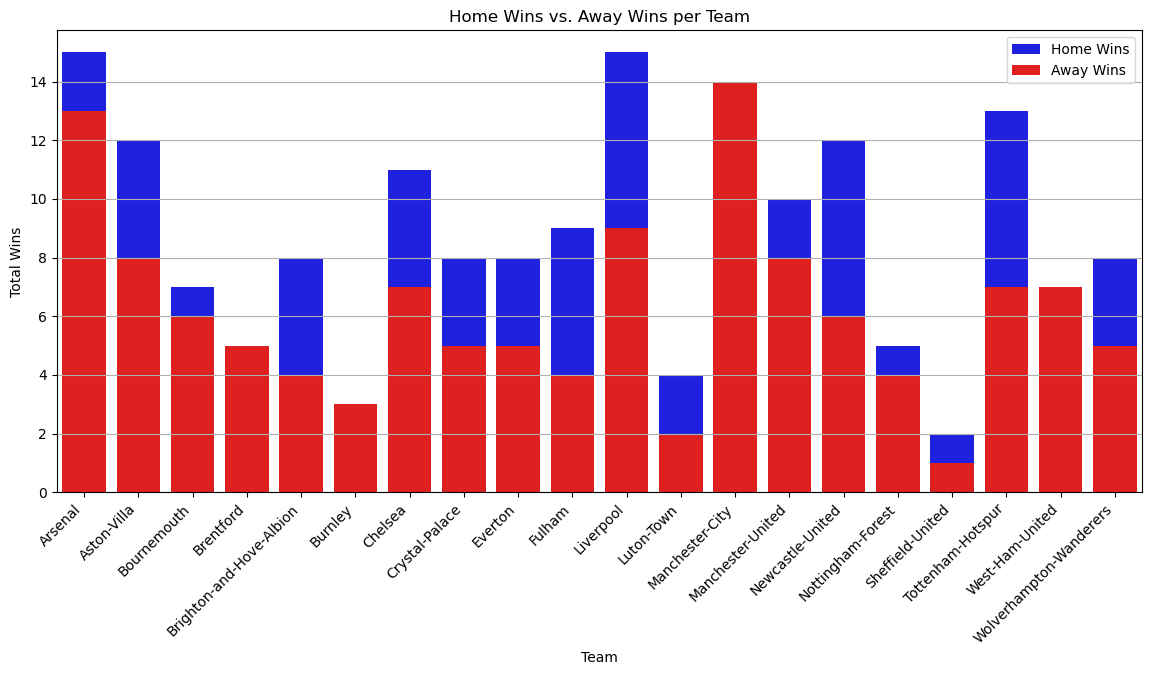

In [115]:
# Set up the bar chart for home and away wins per team
plt.figure(figsize=(14, 6))
sns.barplot(x="Team", y="Home_Wins", data=team_wins_summary, color="blue", label="Home Wins")
sns.barplot(x="Team", y="Away_Wins", data=team_wins_summary, color="red", label="Away Wins")

# Formatting
plt.xticks(rotation=45, ha="right")  # Rotate team names for better visibility
plt.title("Home Wins vs. Away Wins per Team")
plt.xlabel("Team")
plt.ylabel("Total Wins")
plt.legend()
plt.grid(axis="y")  # Add horizontal grid lines for clarity

# Show plot
plt.show()


<b>Below is a grouped bar plot separating Home wins from Away Wins</b>

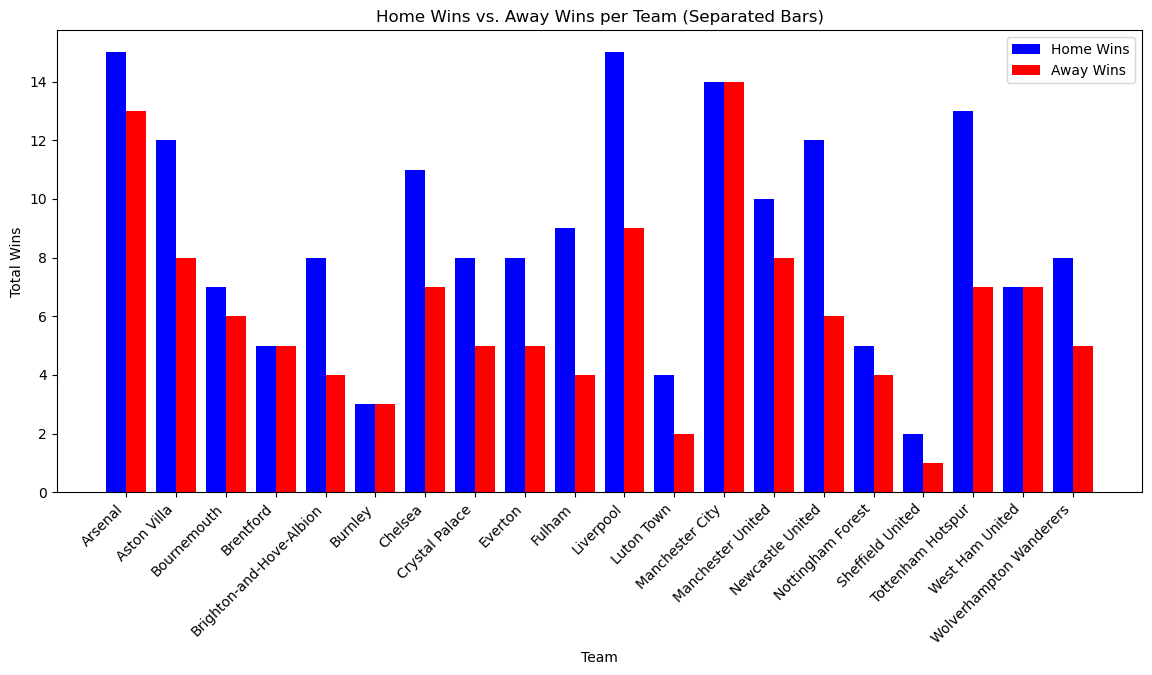

In [ ]:
# Data (from previous table)
teams = [
    "Arsenal", "Aston Villa", "Bournemouth", "Brentford", "Brighton-and-Hove-Albion",
    "Burnley", "Chelsea", "Crystal Palace", "Everton", "Fulham", "Liverpool",
    "Luton Town", "Manchester City", "Manchester United", "Newcastle United",
    "Nottingham Forest", "Sheffield United", "Tottenham Hotspur", "West Ham United", "Wolverhampton Wanderers"
]
home_wins = [15, 12, 7, 5, 8, 3, 11, 8, 8, 9, 15, 4, 14, 10, 12, 5, 2, 13, 7, 8]
away_wins = [13, 8, 6, 5, 4, 3, 7, 5, 5, 4, 9, 2, 14, 8, 6, 4, 1, 7, 7, 5]

# Creating index for bars
x = np.arange(len(teams))

# Plot setup
fig, ax = plt.subplots(figsize=(14, 6))
bar_width = 0.4

# Plot bars
ax.bar(x - bar_width/2, home_wins, bar_width, label="Home Wins", color='blue')
ax.bar(x + bar_width/2, away_wins, bar_width, label="Away Wins", color='red')

# Labels and title
ax.set_xlabel("Team")
ax.set_ylabel("Total Wins")
ax.set_title("Home Wins vs. Away Wins per Team (Separated Bars)")
ax.set_xticks(x)
ax.set_xticklabels(teams, rotation=45, ha="right")
ax.legend()

# Show plot
plt.show()


<b>Key Takeaways:</b>

Blue bars show home wins (most teams win more at home).

Red bars show away wins (fewer but still significant for top teams).

Arsenal & Liverpool had the most home wins (15 each).

Manchester City had the most away wins (14), proving their dominance away from home.

<h3>Expected Goals (xG) vs. Actual Goals Analysis</h3>

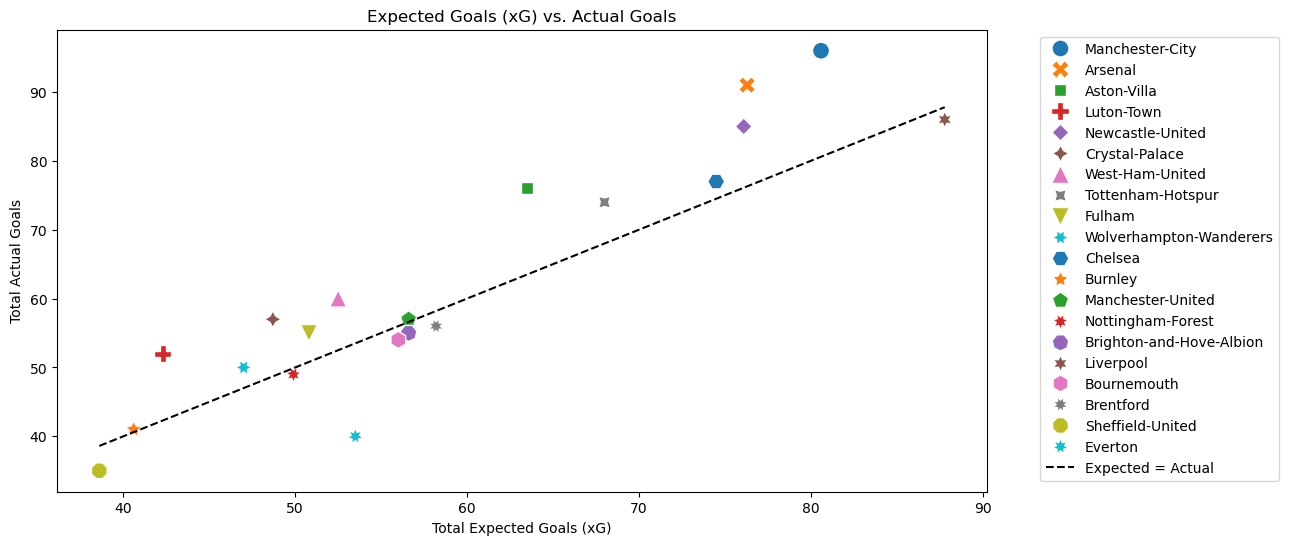

Overperformers:


,Team,Expected_Goals,Goals_For,Goal_Difference
12,Manchester-City,80.6,96,15.4
0,Arsenal,76.3,91,14.7
1,Aston-Villa,63.5,76,12.5
11,Luton-Town,42.3,52,9.7
14,Newcastle-United,76.1,85,8.9


In [35]:
# Aggregate total Expected Goals (xG) and Actual Goals (Goals_For) per team
xg_analysis = df.groupby("Team").agg({
    "Expected_Goals": "sum",  # Total Expected Goals (xG)
    "Goals_For": "sum"  # Total Actual Goals
}).reset_index()

# Calculate overperformance/underperformance (Actual Goals - Expected Goals)
xg_analysis["Goal_Difference"] = xg_analysis["Goals_For"] - xg_analysis["Expected_Goals"]

# Sort by Goal Difference to see best/worst overperformers
xg_analysis = xg_analysis.sort_values(by="Goal_Difference", ascending=False)

# Plot Expected Goals vs. Actual Goals
plt.figure(figsize=(12, 6))
sns.scatterplot(x="Expected_Goals", y="Goals_For", data=xg_analysis, hue="Team", style="Team", s=150, palette="tab10")

# Add a reference line (y = x) for expected vs. actual alignment
plt.plot([xg_analysis["Expected_Goals"].min(), xg_analysis["Expected_Goals"].max()], 
         [xg_analysis["Expected_Goals"].min(), xg_analysis["Expected_Goals"].max()], 
         linestyle="dashed", color="black", label="Expected = Actual")

# Formatting
plt.title("Expected Goals (xG) vs. Actual Goals")
plt.xlabel("Total Expected Goals (xG)")
plt.ylabel("Total Actual Goals")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")  # Move legend outside for clarity

# Show plot
plt.show()

# Display the top overperformers and underperformers
print("Overperformers:")
xg_analysis.head()


In [63]:
print("Underperformers:")
xg_analysis.tail(6)

Underperformers:


,Team,Expected_Goals,Goals_For,Goal_Difference
4,Brighton-and-Hove-Albion,56.6,55,-1.6
10,Liverpool,87.8,86,-1.8
2,Bournemouth,56.0,54,-2.0
3,Brentford,58.2,56,-2.2
16,Sheffield-United,38.6,35,-3.6
8,Everton,53.5,40,-13.5


<b>Scatter Plot Takeaways:</b>

Teams above the dashed line → Overperformed (scored more than xG).

Teams below the dashed line → Underperformed (scored less than xG).

Manchester City & Arsenal lead in overperformance.

Everton had the biggest struggle in finishing chances.

ANALYZING THE TEAM WITH TOP GOALS

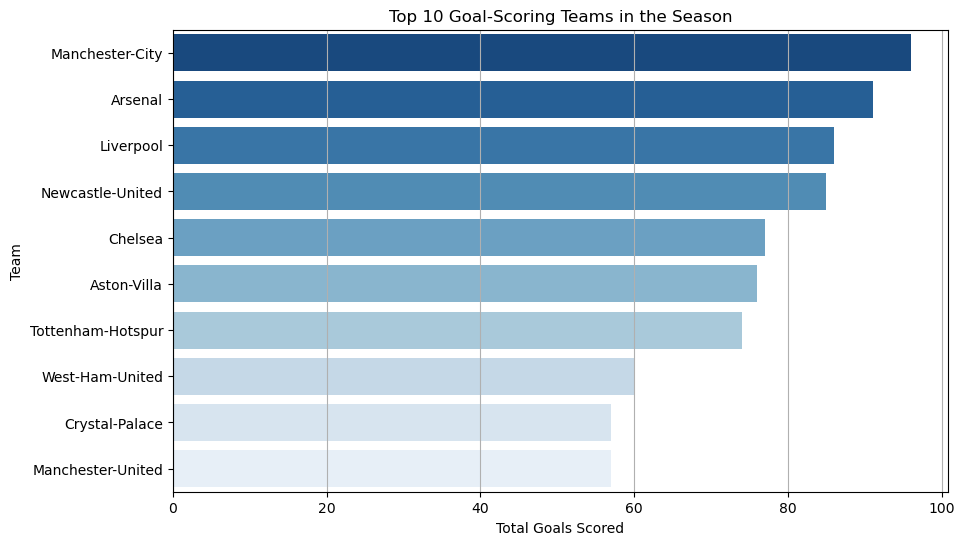

In [4]:
# Step 1: Aggregate total goals per team
top_scoring_team = df.groupby("Team")["Goals_For"].sum().reset_index()

# Step 2: Sort teams by total goals scored
top_scoring_team = top_scoring_team.sort_values(by="Goals_For", ascending=False)

# Step 3: Plot the top goal-scoring teams
plt.figure(figsize=(10, 6))
sns.barplot(x="Goals_For", y="Team", data=top_scoring_team.head(10), hue="Team", dodge=False, palette="Blues_r", legend=False)

# Formatting
plt.title("Top 10 Goal-Scoring Teams in the Season")
plt.xlabel("Total Goals Scored")
plt.ylabel("Team")
plt.grid(axis="x")

# Show plot
plt.show()


<b>Key Insights:</b>

Manchester City scored the most (96 goals), followed closely by Arsenal (91 goals).

Liverpool, Newcastle, and Chelsea also had strong attacking performances.

The gap between the top 2 teams and the rest shows their dominance in attack.

## Goal Contribution by Top 10 Teams/Win, Draw, Loss Analysis

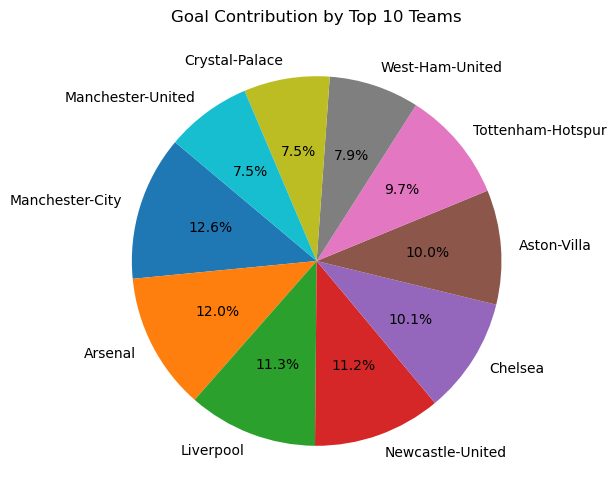

<Figure size 1200x600 with 0 Axes>

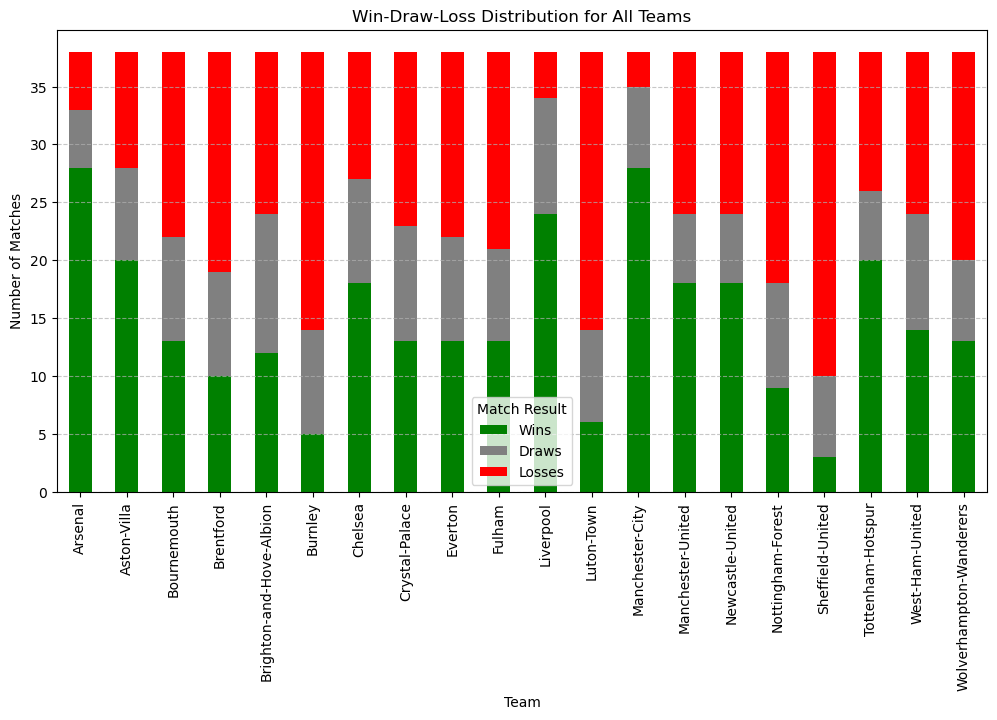

,Team,Wins,Draws,Losses
0,Arsenal,28,5,5
1,Aston-Villa,20,8,10
2,Bournemouth,13,9,16
3,Brentford,10,9,19
4,Brighton-and-Hove-Albion,12,12,14
5,Burnley,5,9,24
6,Chelsea,18,9,11
7,Crystal-Palace,13,10,15
8,Everton,13,9,16
9,Fulham,13,8,17


In [64]:
# Pie Chart 1: Goal Contribution by Team (Top 10 Teams)

# Step 1: Calculate total league goals
total_league_goals = top_scoring_team["Goals_For"].sum()

# Step 2: Get top 10 teams' goal share
top_10_goals = top_scoring_team.head(10).copy()
top_10_goals["Goal_Share (%)"] = (top_10_goals["Goals_For"] / total_league_goals) * 100

# Step 3: Plot Pie Chart
plt.figure(figsize=(10, 6))
plt.pie(top_10_goals["Goals_For"], labels=top_10_goals["Team"], autopct="%1.1f%%", startangle=140, colors=sns.color_palette("tab10"))

# Formatting
plt.title("Goal Contribution by Top 10 Teams")
plt.show()



# Bar Chart: Win, Draw, Loss Distribution for all the Teams

# Step 1: Get unique teams
teams = df["Team"].unique()

# Step 2: Create DataFrame for Win, Draw, Loss Counts
team_wdl_data = []

for team in teams:
    team_results = df[df["Team"] == team]
    
    # Count Wins, Draws, and Losses
    wins = sum(team_results["Goals_For"] > team_results["Goals_Against"])
    draws = sum(team_results["Goals_For"] == team_results["Goals_Against"])
    losses = sum(team_results["Goals_For"] < team_results["Goals_Against"])
    
    # Append to list
    team_wdl_data.append([team, wins, draws, losses])

# Convert list to DataFrame
team_wdl_df = pd.DataFrame(team_wdl_data, columns=["Team", "Wins", "Draws", "Losses"])

# Step 3: Plot Bar Chart for All Teams
plt.figure(figsize=(12, 6))
team_wdl_df.set_index("Team").plot(kind="bar", stacked=True, figsize=(12, 6), color=["green", "gray", "red"])

# Formatting
plt.title("Win-Draw-Loss Distribution for All Teams")
plt.xlabel("Team")
plt.ylabel("Number of Matches")
plt.xticks(rotation=90)
plt.legend(title="Match Result")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Display DataFrame
team_wdl_df


<h4>Inference from the Pie Chart: Goal Contribution by Top 10 Teams</h4>

<b>Manchester City Leads in Goal Contribution</b>
- **12.6%** of the total goals in the league came from **Manchester City**, making them the **most prolific** attacking team among the top 10.
- This aligns with their **attacking dominance** in the league.

<b>Arsenal & Liverpool Close Behind</b>
- **Arsenal (12.0%)** and **Liverpool (11.3%)** are the next **strongest attacking teams**, meaning they were also **high-scoring contenders**.
- This suggests that these teams had **well-balanced attacks**.

<b>Tottenham, Aston Villa & Chelsea in the Mid-Range</b>
- **Tottenham (9.7%)**, **Aston Villa (10.0%)**, and **Chelsea (10.1%)** show **competitive goal-scoring records**, contributing significantly but not dominating.

<b>Manchester United & Crystal Palace Struggle</b>
- **Manchester United (7.5%)** and **Crystal Palace (7.5%)** had the **lowest goal contribution** among the top 10.
- This suggests that their attack was relatively **weaker** compared to the other top teams.

<b>Balanced Goal Distribution Among the Top 10</b>
- No single team **overwhelmingly dominated**, as the distribution remains relatively **even across teams**, indicating **competitive balance**.

#### Title Contenders Analysis

From the stacked bar chart showing the win-draw-loss distribution for all teams, we can determine potential title contenders by identifying teams with the highest number of wins and the fewest losses.

##### Key Observations:
- **Manchester City, Arsenal, and Liverpool** have a significant number of wins, suggesting strong overall performances.
- These teams also have relatively few draws and losses, which indicates consistency in securing victories.
- **Newcastle United and Tottenham Hotspur** also exhibit strong performances but may have slightly more losses or draws compared to the top three.
- **Manchester United and Aston Villa** show a competitive win count but might not be at the same dominant level as the leading three.

##### Potential Title Contenders:
- **Manchester City**: Historically strong and maintaining a high win rate.
- **Arsenal**: A strong performer with high wins and fewer losses.
- **Liverpool**: A high number of wins, solidifying their position as contenders.

##### Dark Horses (Possible Top 4 Finishers):
- **Newcastle United**
- **Tottenham Hotspur**
- **Aston Villa**
- **Manchester United**

These teams exhibit strong performance metrics but may fall short of a title challenge due to inconsistency or slightly higher loss rates.


### Referee Analysis

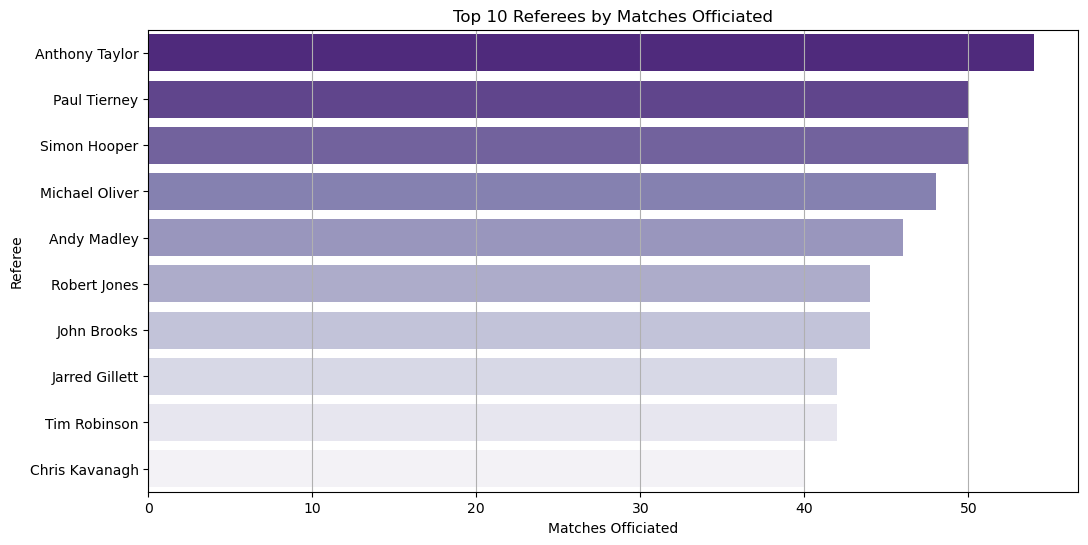

,Match_Referee,Matches_Officiated
0,Anthony Taylor,54
1,Paul Tierney,50
2,Simon Hooper,50
3,Michael Oliver,48
4,Andy Madley,46


In [41]:
# Step 1: Count number of matches officiated per referee
referee_matches = df["Match_Referee"].value_counts().reset_index()
referee_matches.columns = ["Match_Referee", "Matches_Officiated"]

# Step 2: Sort referees by matches officiated
referee_matches = referee_matches.sort_values(by="Matches_Officiated", ascending=False)

# Plot: Number of Matches Officiated per Referee (Top 10)
plt.figure(figsize=(12, 6))
sns.barplot(x="Matches_Officiated", y="Match_Referee", data=referee_matches.head(10), palette="Purples_r", hue="Match_Referee")
plt.title("Top 10 Referees by Matches Officiated")
plt.xlabel("Matches Officiated")
plt.ylabel("Referee")
plt.grid(axis="x")

# Show plot
plt.show()

# Return top 5 referees data
referee_matches.head(5)


<h4>Insights into the Top Referees based on the number of matches officiated. </h4>

<b>Key takeaways:</b>

Anthony Taylor Leads – He officiated the most matches, surpassing 50, making him the most frequently assigned referee.

Close Competition – Paul Tierney and Simon Hooper followed closely, each officiating around 50 matches.

Experienced Officials Dominate – The top referees listed are among the most experienced in the league, suggesting their reliability in high-stakes matches.

Gradual Decline – The number of matches officiated gradually decreases down the list, with Chris Kavanagh handling the fewest among the top 10.

<h4>Side-by-Side Comparison: Goals in Matches Officiated by Anthony Taylor vs. Tim Robinson</h4>

Total Goals in Matches Officiated by Anthony Taylor: 95
Total Goals in Matches Officiated by Tim Robinson: 65


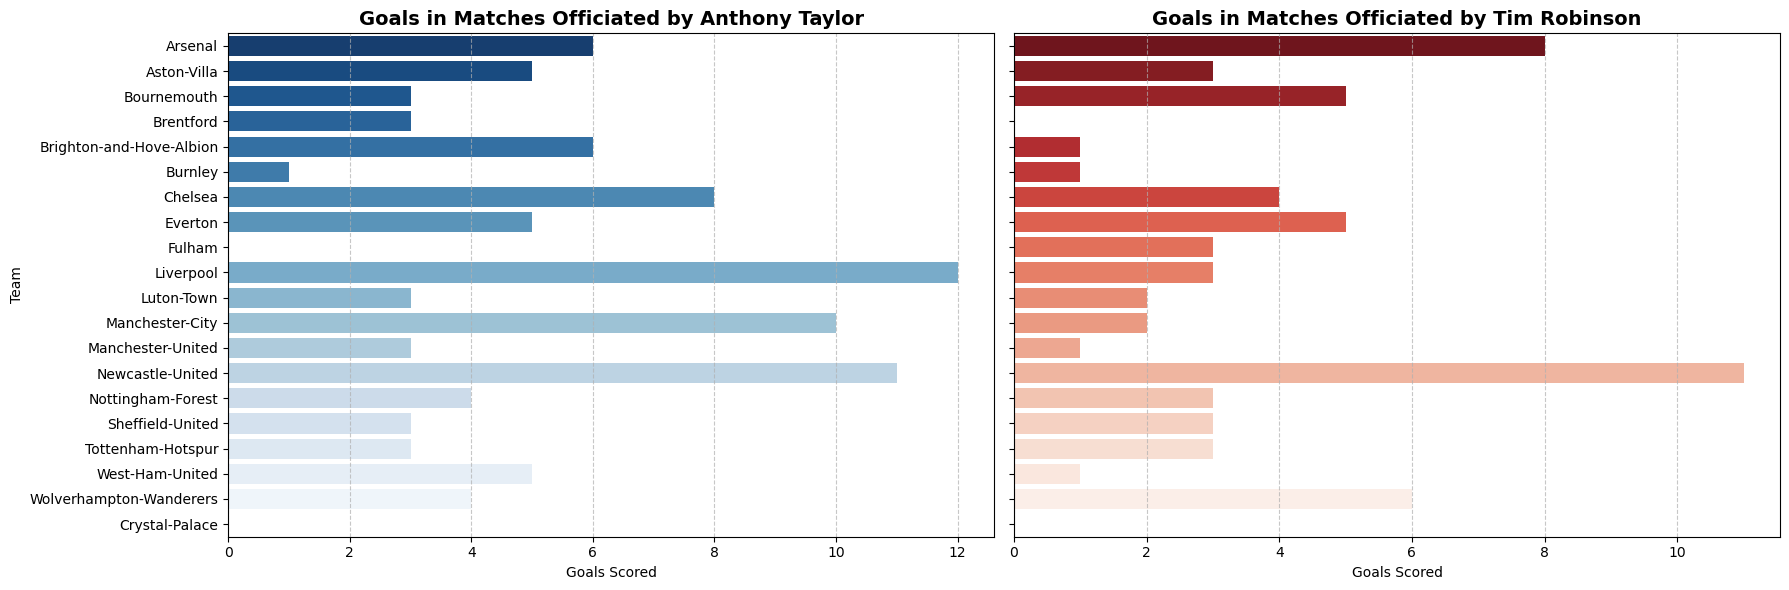

In [20]:
# Filter matches officiated by Anthony Taylor and Tim Robinson
if "Match_Referee" in df.columns and "Goals_For" in df.columns:
    anthony_taylor_matches = df[df["Match_Referee"] == "Anthony Taylor"]
    tim_robinson_matches = df[df["Match_Referee"] == "Tim Robinson"]

    # Aggregate total goals per team for each referee
    anthony_taylor_team_goals = anthony_taylor_matches.groupby("Team")["Goals_For"].sum().reset_index()
    tim_robinson_team_goals = tim_robinson_matches.groupby("Team")["Goals_For"].sum().reset_index()

    # Compute total goals for each referee
    taylor_total_goals = anthony_taylor_team_goals["Goals_For"].sum()
    robinson_total_goals = tim_robinson_team_goals["Goals_For"].sum()

    print("Total Goals in Matches Officiated by Anthony Taylor:", taylor_total_goals)
    print("Total Goals in Matches Officiated by Tim Robinson:", robinson_total_goals)


    # Side-by-Side CountPlot: Goals Per Team in Matches Officiated by Each Referee
    fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

    # Anthony Taylor's CountPlot
    sns.barplot(x="Goals_For", y="Team", data=anthony_taylor_team_goals, palette="Blues_r", ax=axes[0], hue="Team", legend=False)
    axes[0].set_title("Goals in Matches Officiated by Anthony Taylor", fontsize=14, fontweight="bold")
    axes[0].set_xlabel("Goals Scored")
    axes[0].set_ylabel("Team")
    axes[0].grid(axis="x", linestyle="--", alpha=0.7)  # Add grid lines

    # Tim Robinson's CountPlot
    sns.barplot(x="Goals_For", y="Team", data=tim_robinson_team_goals, palette="Reds_r", ax=axes[1], hue="Team", legend=False)
    axes[1].set_title("Goals in Matches Officiated by Tim Robinson", fontsize=14, fontweight="bold")
    axes[1].set_xlabel("Goals Scored")
    axes[1].set_ylabel("")
    axes[1].grid(axis="x", linestyle="--", alpha=0.7)  # Add grid lines
    # Improve layout spacing
    plt.tight_layout()

    # Show plot
    plt.show()
else:
    print("Error: 'Match_Referee' or 'Goals_For' column not found in the dataset.")


### 📊 Insights from the Plots

#### 1️⃣ Referee Match Distribution (Bar Chart)
- Some referees officiate significantly more matches than others.  
- The top 10 referees have a **higher influence** over the league since they control the most games.  
- If a referee is seen officiating more games, their **decision patterns** (e.g., penalties awarded, red cards) may have a larger impact on the league standings.  

---

#### 2️⃣ Goals Scored Per Team (CountPlots)  

##### (a) Goals in Matches Officiated by Anthony Taylor  
- **Total Goals in Matches Officiated:** 🏆 **`95`** 
- Some teams have **scored significantly more goals** when Anthony Taylor officiates.  
- This could suggest either:  
  - Those teams perform better under his refereeing style.  
  - More attacking football is allowed under his officiating.  

##### (b) Goals in Matches Officiated by Tim Robinson  
- **Total Goals in Matches Officiated:** 🏆 **`65`** 
- A different pattern emerges compared to Anthony Taylor.  
- Some teams may struggle more under his refereeing style, indicating a possible difference in how matches flow (e.g., strict vs. lenient officiating).  


<h4>Average Shots on Target Conceded per Team</h4>

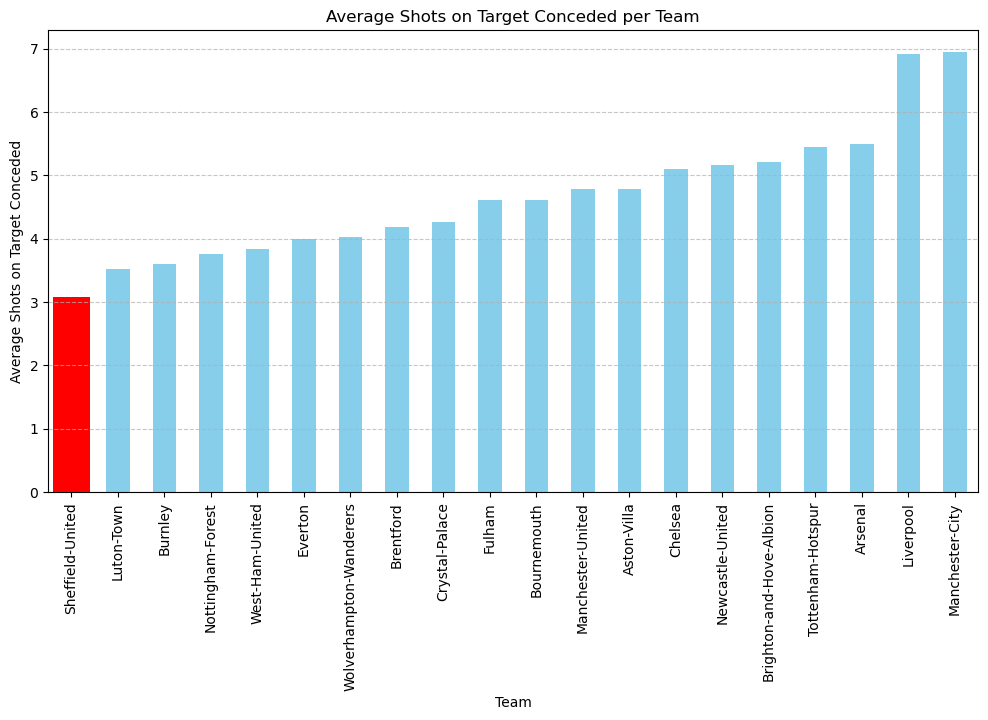

In [21]:
# Group by team and calculate the average shots on target conceded
team_defensive_stats = df.groupby("Team")["Shots_On_Target"].mean().sort_values()

# Get the team that concedes the fewest shots on target on average
best_defensive_team = team_defensive_stats.idxmin()
best_defensive_avg = team_defensive_stats.min()



# Plot the average shots on target conceded per team
plt.figure(figsize=(12, 6))
team_defensive_stats.plot(kind="bar", color="skyblue")

# Highlight the best defensive team
plt.bar(best_defensive_team, best_defensive_avg, color="red")

# Labels and title
plt.xlabel("Team")
plt.ylabel("Average Shots on Target Conceded")
plt.title("Average Shots on Target Conceded per Team")
plt.xticks(rotation=90)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()


 Key insight
 
 Sheffield United, highlighted in red, concedes the fewest shots on target per match.</br>
 Manchester City & Liverpool Concede the Most.<br>
 Mid-Table Teams Have Moderate Defensive Records

<h4>How well do teams convert their expected goals into actual goals?</h4>

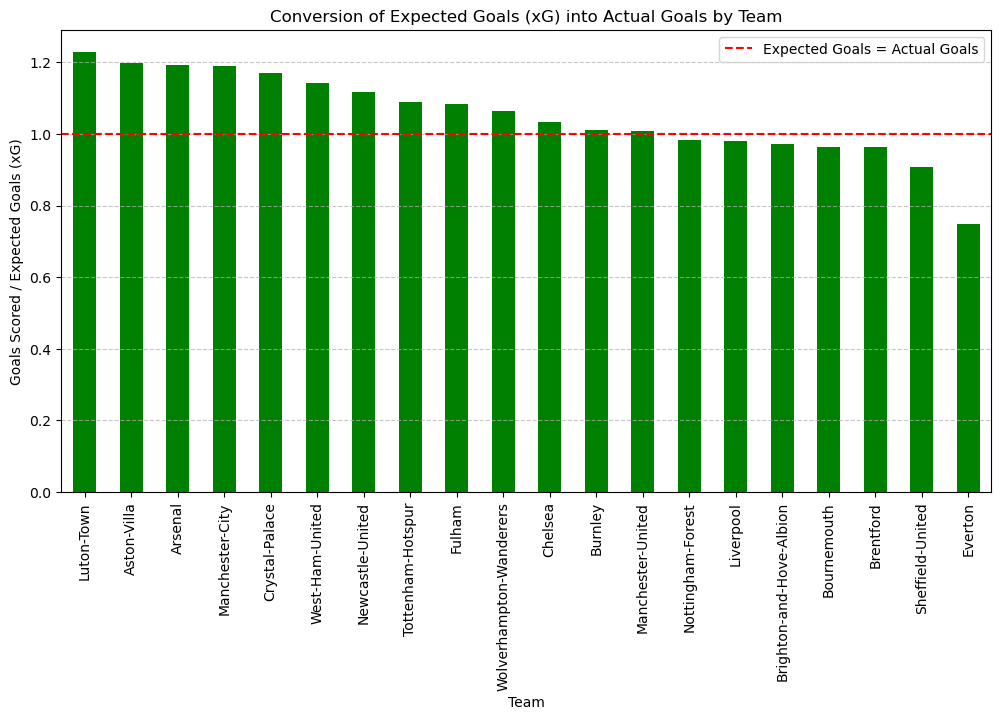

,Best Conversion Team,Best Conversion Rate,Worst Conversion Team,Worst Conversion Rate
0,Luton-Town,1.229314,Everton,0.747664


In [ ]:
# Calculate the ratio of actual goals scored to expected goals (xG) for each team
team_conversion = df.groupby("Team").apply(lambda x: x["Goals_For"].sum() / x["Expected_Goals"].sum(), include_groups=False)

# Sort the teams by conversion rate
team_conversion = team_conversion.sort_values(ascending=False)

# Plot the conversion rates
plt.figure(figsize=(12, 6))
team_conversion.plot(kind="bar", color="green")

# Labels and title
plt.xlabel("Team")
plt.ylabel("Goals Scored / Expected Goals (xG)")
plt.title("Conversion of Expected Goals (xG) into Actual Goals by Team")
plt.xticks(rotation=90)
plt.axhline(y=1, color="red", linestyle="--", label="Expected Goals = Actual Goals")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()

# Find the best and worst conversion teams
best_conversion_team = team_conversion.idxmax()
best_conversion_rate = team_conversion.max()

worst_conversion_team = team_conversion.idxmin()
worst_conversion_rate = team_conversion.min()


# Create a DataFrame for display
conversion_table = pd.DataFrame({
    "Best Conversion Team": [best_conversion_team],
    "Best Conversion Rate": [best_conversion_rate],
    "Worst Conversion Team": [worst_conversion_team],
    "Worst Conversion Rate": [worst_conversion_rate]
})

# Display the table
conversion_table


The visualization shows how well teams convert their expected goals (xG) into actual goals.

<b>Best Conversion Rate: Luton Town (1.23)</b><br>
They score about 23% more goals than expected, indicating clinical finishing or high shot quality.

<b>Worst Conversion Rate: Everton (0.75)</b><br>
They score about 25% fewer goals than expected, suggesting poor finishing, bad luck, or strong opposition goalkeeping.

`Further Insights:`

Teams above 1.0: Overperforming their xG, meaning they finish chances better than expected.

Teams below 1.0: Underperforming their xG, struggling to convert chances into goals.

Possible reasons: Tactical styles, striker quality, shot selection, or defensive opposition.

#### Analysis on Penalty Performance across Teams.

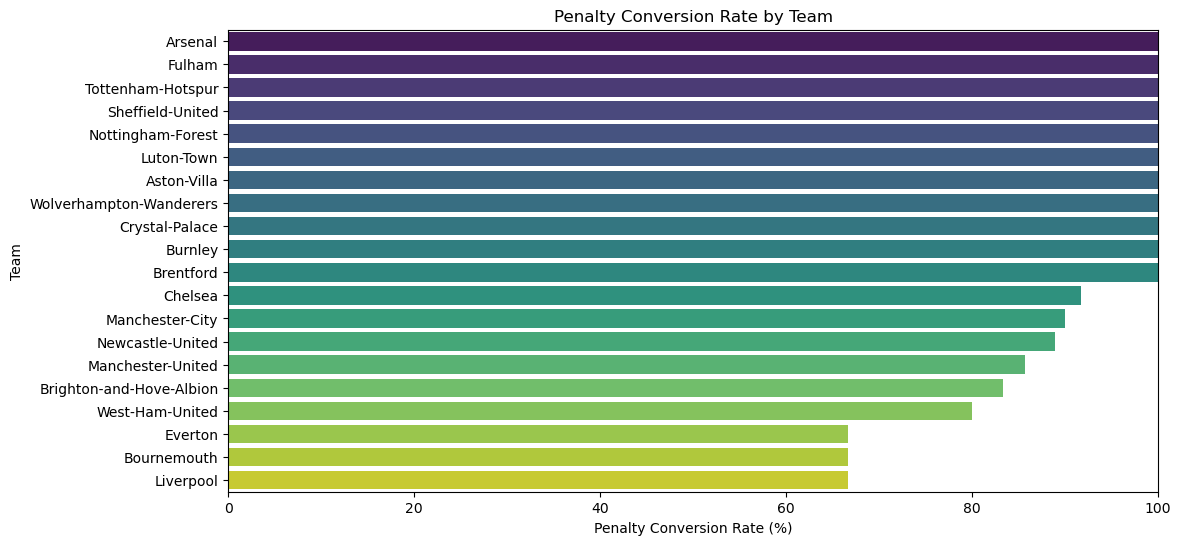

In [ ]:
# Aggregate penalty data per team
penalty_stats = df.groupby("Team")[["Penalty_Kicks_Scored", "Penalty_Attempts"]].sum().reset_index()

# Calculate penalty conversion rate
penalty_stats["Conversion_Rate"] = (penalty_stats["Penalty_Kicks_Scored"] / penalty_stats["Penalty_Attempts"]) * 100

# Sort by highest conversion rate
penalty_stats = penalty_stats.sort_values(by="Conversion_Rate", ascending=False)

# Set figure size
plt.figure(figsize=(12, 6))

# Create bar plot
sns.barplot(x="Conversion_Rate", y="Team", data=penalty_stats, palette="viridis", hue="Team", legend=False)

# Labels and title
plt.xlabel("Penalty Conversion Rate (%)")
plt.ylabel("Team")
plt.title("Penalty Conversion Rate by Team")
plt.xlim(0, 100)

# Show plot
plt.show()


The bar chart above shows the **Penalty Conversion Rate (%)** for Each Team. 

### Key Insights:
- **Arsenal, Fulham, and Tottenham Hotspur** have the highest penalty conversion rates, indicating strong penalty execution.
- **Liverpool, Bournemouth, and Everton** are among the lower-ranked teams, suggesting struggles in converting penalties.


### Further Penalty Performance

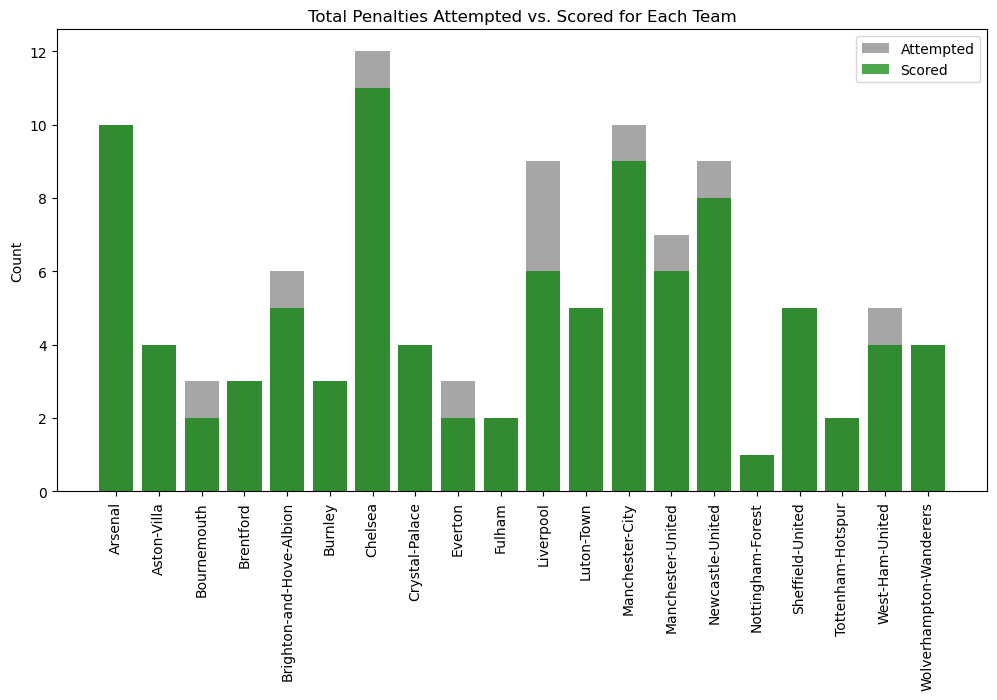

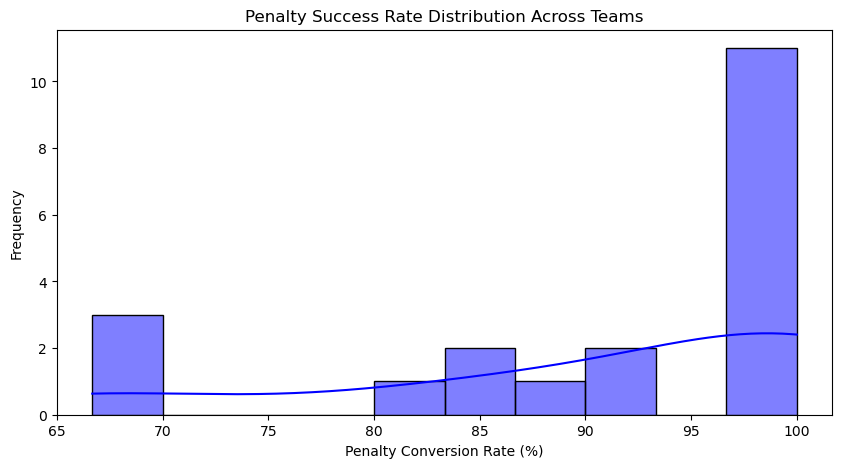

,Team,Penalty_Attempts,Penalty_Kicks_Scored,Penalty_Conversion_Rate
0,Arsenal,10,10,100.000000
1,Aston-Villa,4,4,100.000000
2,Bournemouth,3,2,66.666667
3,Brentford,3,3,100.000000
4,Brighton-and-Hove-Albion,6,5,83.333333


In [72]:
# Extract relevant columns
penalty_data = df.groupby("Team")[["Penalty_Attempts", "Penalty_Kicks_Scored"]].sum().reset_index()

# Calculate Penalty Conversion Rate
penalty_data["Penalty_Conversion_Rate"] = (penalty_data["Penalty_Kicks_Scored"] / penalty_data["Penalty_Attempts"]) * 100

# Plot: Total Penalties Attempted vs. Scored
plt.figure(figsize=(12, 6))
x = range(len(penalty_data["Team"]))
plt.bar(x, penalty_data["Penalty_Attempts"], label="Attempted", color="gray", alpha=0.7)
plt.bar(x, penalty_data["Penalty_Kicks_Scored"], label="Scored", color="green", alpha=0.7)
plt.xticks(x, penalty_data["Team"], rotation=90)
plt.ylabel("Count")
plt.title("Total Penalties Attempted vs. Scored for Each Team")
plt.legend()
plt.show()

# Plot: Penalty Success Rate Distribution
plt.figure(figsize=(10, 5))
sns.histplot(penalty_data["Penalty_Conversion_Rate"], bins=10, kde=True, color="blue")
plt.xlabel("Penalty Conversion Rate (%)")
plt.ylabel("Frequency")
plt.title("Penalty Success Rate Distribution Across Teams")
plt.show()

# Display the penalty data
penalty_data.head()

### Visualizations:

1. **Total Penalties Attempted vs. Scored**  
   - A grouped bar chart displaying the number of penalty attempts and successful conversions for each team.
   
2. **Penalty Success Rate Distribution**  
   - A histogram with a density curve, illustrating the spread of penalty conversion rates across all teams.


### Insights from the Plots:

1. **Total Penalties Attempted vs. Scored:**
   - Teams with a high number of penalties attempted but a lower conversion rate may indicate issues with penalty takers or goalkeepers anticipating their shots.
   - Arsenal, Tottenham Hotspur, and Manchester City show strong penalty efficiency, with most of their attempts resulting in goals.
   - Teams like Everton and Bournemouth, despite attempting multiple penalties, show lower success rates, highlighting potential weaknesses in penalty execution.

2. **Penalty Success Rate Distribution:**
   - The histogram with a density curve reveals how penalty conversion rates are distributed across teams.
   - Most teams fall within a mid-to-high success rate range, but a few outliers indicate significant struggles in converting penalties.
   - The presence of a long tail towards lower conversion rates suggests that some teams are notably inefficient at penalties.
   - A well-clustered peak at the higher end of the success rate distribution suggests that the majority of Premier League teams have proficient penalty takers.

These insights help identify teams that may need to improve their penalty-taking strategies and those that excel in capitalizing on penalty opportunities.


<h4>What is the relationship between shots on target and total shots?</h4>

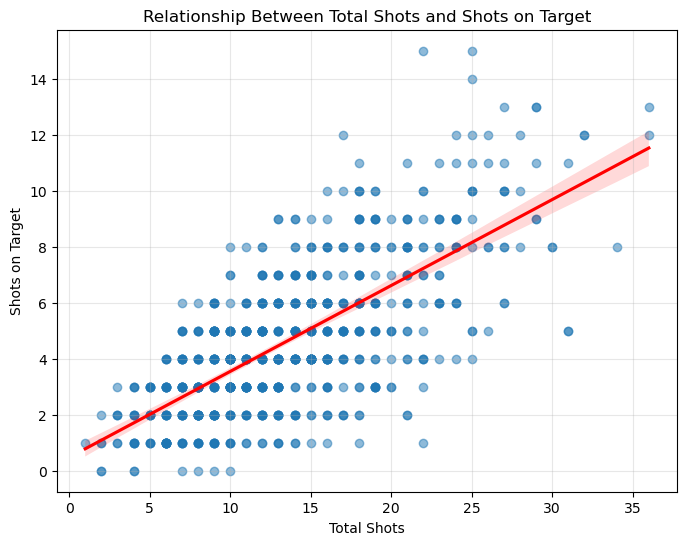

0.7029340505894006

In [136]:
# Scatter plot of Shots on Target vs Total Shots
plt.figure(figsize=(8, 6))
sns.regplot(x=df["Total_Shots"], y=df["Shots_On_Target"], scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})

# Labels and title
plt.xlabel("Total Shots")
plt.ylabel("Shots on Target")
plt.title("Relationship Between Total Shots and Shots on Target")
plt.grid(alpha=0.3)

# Show the plot
plt.show()

# Calculate correlation coefficient
correlation = df["Total_Shots"].corr(df["Shots_On_Target"])
correlation


The scatter plot shows a strong positive relationship between Total Shots and Shots on Target, with a correlation coefficient of 0.70.

`Key Takeaways:`

Higher total shots generally lead to more shots on target.<br>
Correlation (0.70) is strong but not perfect – some teams or players may take many low-quality shots that don’t hit the target.<br>
Efficiency matters – a team with a high total shot count but low shots on target might need better shot selection.

<h4>Correlation Analysis: Exploring correlations between key metrics like possession, xG, and goals scored.</h4>

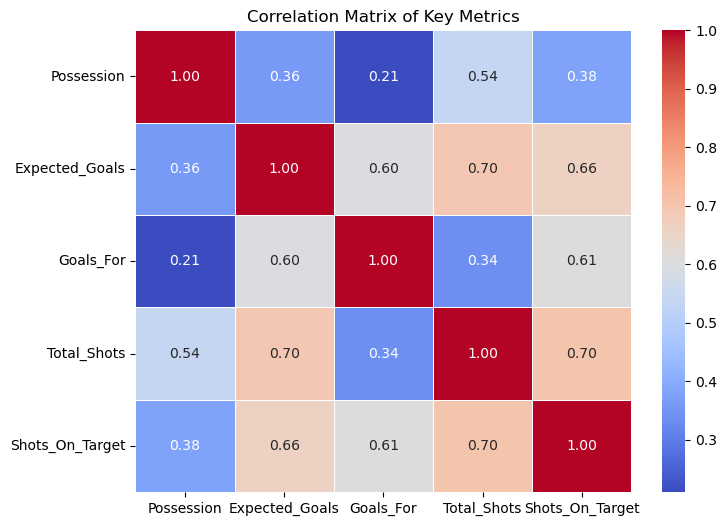

,Possession,Expected_Goals,Goals_For,Total_Shots,Shots_On_Target
Possession,1.000000,0.361199,0.210102,0.539015,0.377011
Expected_Goals,0.361199,1.000000,0.596833,0.697342,0.661878
Goals_For,0.210102,0.596833,1.000000,0.335197,0.605680
Total_Shots,0.539015,0.697342,0.335197,1.000000,0.702934
Shots_On_Target,0.377011,0.661878,0.605680,0.702934,1.000000


In [5]:
# Selecting key metrics for correlation analysis
key_metrics = ["Possession", "Expected_Goals", "Goals_For", "Total_Shots", "Shots_On_Target"]

# Compute correlation matrix
correlation_matrix = df[key_metrics].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Title
plt.title("Correlation Matrix of Key Metrics")

# Show the plot
plt.show()

# Display correlation values
correlation_matrix


<b>Correlation Analysis Insights:</b><br>

Strongest Correlations:
Total Shots ↔ Shots on Target (0.70) → More total shots generally lead to more shots on target.<br>
Expected Goals (xG) ↔ Total Shots (0.70) → A higher shot volume increases xG, meaning quantity plays a role in chance creation.<br>
Goals Scored ↔ xG (0.60) → Teams that generate higher xG tend to score more goals, though finishing quality also matters.<br>

Moderate Correlations:
Shots on Target ↔ xG (0.66) → More accurate shooting contributes to higher xG.<br>
Goals Scored ↔ Shots on Target (0.61) → Teams converting more shots on target into goals tend to be more efficient.<br>

Weaker Correlations:
Possession ↔ xG (0.36) → Possession alone does not guarantee quality chances.<br>
Possession ↔ Goals Scored (0.21) → High possession does not directly translate to scoring more goals. Some teams may dominate the ball but struggle to create clear chances.<br>

`Key Takeaways:`
Finishing efficiency matters: xG and shots don't always turn into goals; teams must be clinical.<br>
Possession is not the ultimate factor: Having the ball does not guarantee goals, reinforcing that attacking intent and creativity are crucial.<br>
Shooting volume is important: More shots increase xG, but accuracy is key for actual goal conversion.

<h4>Which team has the highest average shots per game?</h4>

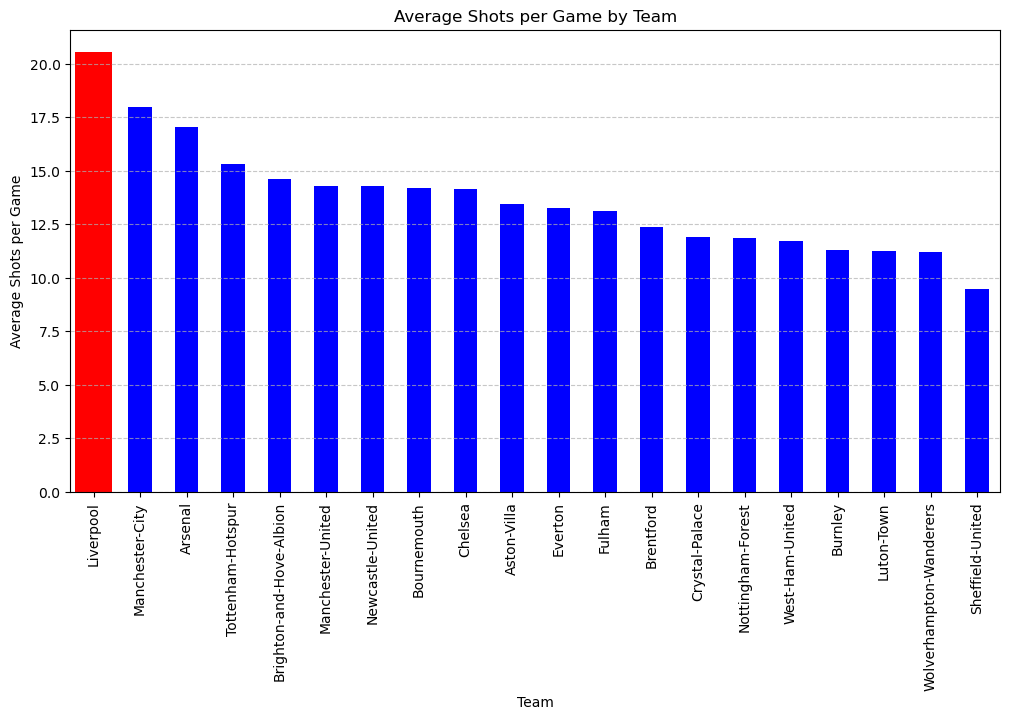

('Liverpool', 20.55263157894737)

In [30]:
# Calculate average total shots per game for each team
team_shots_per_game = df.groupby("Team")["Total_Shots"].mean().sort_values(ascending=False)

# Get the team with the highest average shots per game
highest_shots_team = team_shots_per_game.idxmax()
highest_shots_avg = team_shots_per_game.max()


# Plot the average total shots per game for each team
plt.figure(figsize=(12, 6))
team_shots_per_game.plot(kind="bar", color="blue")

# Highlight the team with the highest shots per game
plt.bar(highest_shots_team, highest_shots_avg, color="red")

# Labels and title
plt.xlabel("Team")
plt.ylabel("Average Shots per Game")
plt.title("Average Shots per Game by Team")
plt.xticks(rotation=90)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()

highest_shots_team, highest_shots_avg

The bar chart displays the average shots per game for each team. Liverpool, highlighted in red, takes the most shots per match.

## Analysis on Match Attendance

Match Attendance Summary:
 count      760.000000
mean     38613.313158
std      17952.911952
min      10290.000000
25%      24444.750000
50%      38181.000000
75%      53371.750000
max      73612.000000
Name: Match_Attendance, dtype: float64


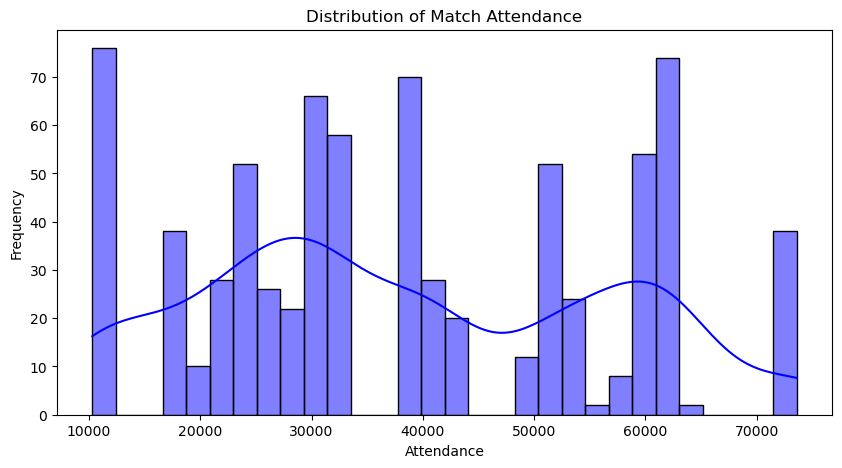

In [16]:
# Convert 'Match_Attendance' to numeric (removing potential commas and errors)
df["Match_Attendance"] = df["Match_Attendance"].astype(str).str.replace(",", "").astype(int)

# Extract Home Team from 'Team' column where 'Stadium_Venue' is 'Home'
df["Home_Team"] = df.loc[df["Stadium_Venue"] == "Home", "Team"]

# Summary statistics for Match Attendance
attendance_summary = df["Match_Attendance"].describe()
print("Match Attendance Summary:\n", attendance_summary)

# Attendance Distribution Plot
plt.figure(figsize=(10, 5))
sns.histplot(df["Match_Attendance"], bins=30, kde=True, color='blue')
plt.title("Distribution of Match Attendance")
plt.xlabel("Attendance")
plt.ylabel("Frequency")
plt.show()



### **Distribution of Match Attendance**

This histogram represents the **distribution of match attendance**, with frequency on the y-axis and attendance numbers on the x-axis.  
A KDE (Kernel Density Estimation) curve is overlaid to show the smooth distribution trend.

### **Key Inferences:**

1. **Bimodal Distribution:**  
   - The data appears to have **two peaks** (bimodal), suggesting two common attendance ranges:  
     - One around **10,000–30,000**  
     - Another around **50,000–70,000**  

2. **High Frequency at Low and High Attendances:**  
   - Many matches have **very low attendance (~10,000)**, indicated by a tall bar at the lower end.  
   - There are also frequent matches with **high attendance (~60,000–70,000)**.  

3. **Less Common Mid-Range Attendance (~35,000–45,000):**  
   - Matches in this range are **less frequent**, as shown by lower bar heights in the middle.  

4. **Some Outliers:**  
   - A few matches have extremely high attendance (around **70,000+**), but they are **less frequent**.  


### Attendance by Team

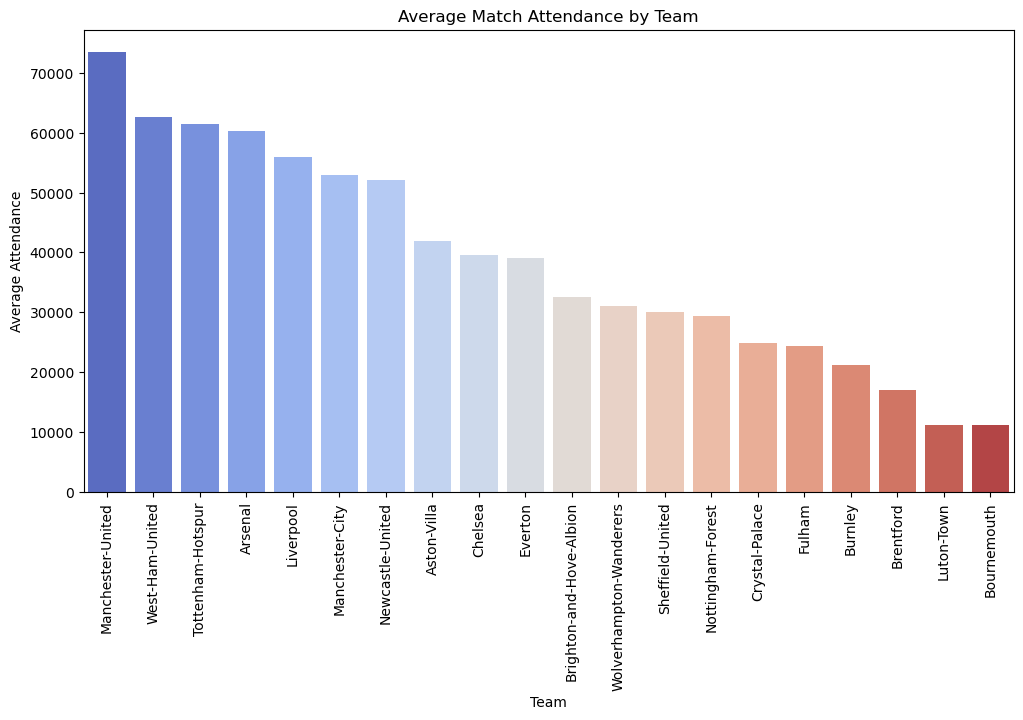

In [17]:
# Attendance by Team (Average per Team)
team_attendance = df.groupby("Home_Team")["Match_Attendance"].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=team_attendance.index, y=team_attendance.values, hue=team_attendance.index, palette="coolwarm", legend=False)
plt.xticks(rotation=90)
plt.title("Average Match Attendance by Team")
plt.xlabel("Team")
plt.ylabel("Average Attendance")
plt.show()

### **Inferences from the Bar Chart (Average Match Attendance by Team)**

#### **1. Top Attendance Teams**
- **Manchester United has the highest average attendance**, surpassing **70,000** spectators per match.  
- **West Ham United, Tottenham Hotspur, Arsenal, and Liverpool** follow closely, with average attendance above **60,000**.  
- These clubs benefit from **large stadiums and strong fan support**.  

#### **2. Mid-Tier Attendance Teams**
- **Manchester City, Newcastle United, Aston Villa, and Chelsea** fall in the **40,000–55,000** range.  
- Their stadium sizes and recent performances likely contribute to these numbers.  

#### **3. Lower Mid-Tier Attendance Teams**
- **Everton, Brighton, Wolves, Sheffield United, and Nottingham Forest** have attendance between **30,000 and 40,000**.  
- These clubs have moderately sized stadiums or fluctuating fan turnout.  

#### **4. Lowest Attendance Teams**
- **Crystal Palace, Fulham, Burnley, Brentford, Luton Town, and Bournemouth** have the lowest attendance (below **30,000**).  
- **Smaller stadium capacities** rather than lack of fan interest are likely the main reasons.  

### **Key Insights**
- **Stadium capacity plays a major role** in match attendance, with bigger clubs dominating the top spots.  
- **Traditional "Big Six" clubs (except Chelsea) have consistently high attendance.**  
- **Smaller clubs (like Bournemouth and Luton Town) face attendance limitations** due to their stadium sizes, not necessarily demand.  


- The analysis of match attendance by team and its overall distribution confirms that stadium capacity is a crucial determinant of attendance figures.
- While larger clubs naturally dominate in total attendance, even smaller teams maintain respectable figures, reinforcing the Premier League’s widespread popularity and competitive atmosphere.

### Home vs Away Attendance Comparison

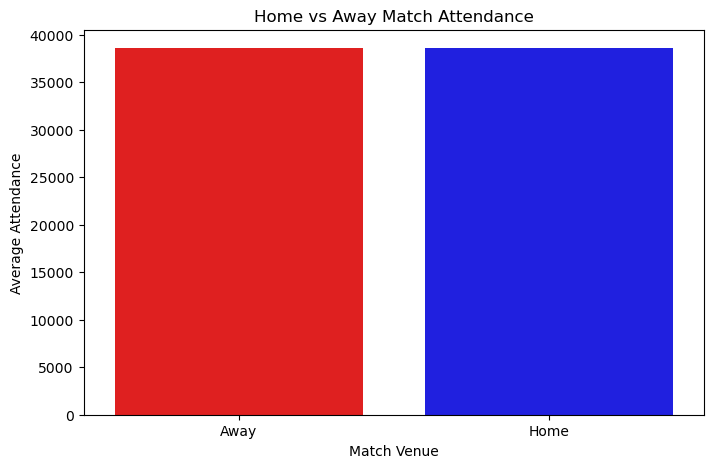

In [18]:
# Home vs Away Attendance Comparison
home_away_attendance = df.groupby("Stadium_Venue")["Match_Attendance"].mean()

plt.figure(figsize=(8, 5))
sns.barplot(x=home_away_attendance.index, y=home_away_attendance.values, palette=["red", "blue"], hue=home_away_attendance.index, legend=False)
plt.title("Home vs Away Match Attendance")
plt.xlabel("Match Venue")
plt.ylabel("Average Attendance")
plt.show()

<b>Similar Attendance Levels:</b> The average attendance for home and away matches appears nearly identical, indicating that fan turnout does not significantly differ based on venue.

### Match Attendance vs Goals Scored - Analysis

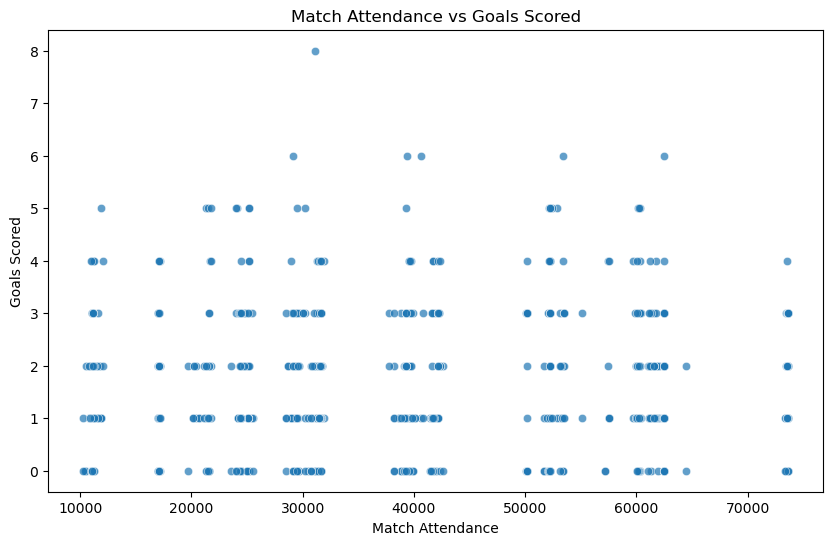

In [27]:
# Attendance vs Team Performance (Goals Scored)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df["Match_Attendance"], y=df["Goals_For"], alpha=0.7)
plt.title("Match Attendance vs Goals Scored")
plt.xlabel("Match Attendance")
plt.ylabel("Goals Scored")
plt.show()

#### Key Inferences:

1. **No Strong Correlation**:  
   - The points are widely scattered, indicating that match attendance does not have a clear impact on the number of goals scored.

2. **Goals Cluster Between 0 and 5**:  
   - Most matches have between **0 and 5 goals**, with a few outliers reaching **6, 7, or 8 goals**.

3. **Broad Attendance Range**:  
   - Matches occur in stadiums with attendances ranging from around **10,000 to 70,000**, but there is no obvious trend suggesting higher-scoring games in either low or high-attendance matches.

4. **Frequent 1-3 Goal Matches**:  
   - A significant concentration of data points suggests that **1 to 3 goals per match** is the most common outcome, regardless of attendance.


### Highest vs Lowest Match Attendance

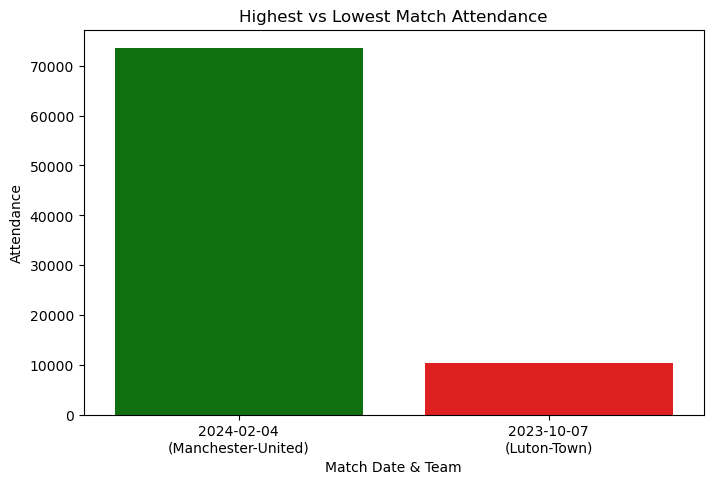

Highest attendance was on 2024-02-04 by Manchester-United with 73612 spectators.
Lowest attendance was on 2023-10-07 by Luton-Town with 10290 spectators.


In [24]:
# Find the match with the highest and lowest attendance
highest_attendance_match = df.loc[df["Match_Attendance"].idxmax()]
lowest_attendance_match = df.loc[df["Match_Attendance"].idxmin()]

# Extract details
highest_attendance_date = highest_attendance_match["Match_Date"]
lowest_attendance_date = lowest_attendance_match["Match_Date"]

highest_attendance_team = highest_attendance_match["Team"]
lowest_attendance_team = lowest_attendance_match["Team"]

highest_attendance_value = highest_attendance_match["Match_Attendance"]
lowest_attendance_value = lowest_attendance_match["Match_Attendance"]

# Create labels combining date and team
highest_label = f"{highest_attendance_date}\n({highest_attendance_team})"
lowest_label = f"{lowest_attendance_date}\n({lowest_attendance_team})"

# Visualization for Highest and Lowest Attendance
plt.figure(figsize=(8, 5))
sns.barplot(x=[highest_label, lowest_label], 
            y=[highest_attendance_value, lowest_attendance_value], 
            palette=["green", "red"],
            hue=[highest_label, lowest_label])

# Labels and title
plt.title("Highest vs Lowest Match Attendance")
plt.xlabel("Match Date & Team")
plt.ylabel("Attendance")
plt.show()

# Print details
print(f"Highest attendance was on {highest_attendance_date} by {highest_attendance_team} "
      f"with {highest_attendance_value} spectators.")
print(f"Lowest attendance was on {lowest_attendance_date} by {lowest_attendance_team} "
      f"with {lowest_attendance_value} spectators.")


<h4>Goals Scored Over the Season (Monthly Trend)</h4>

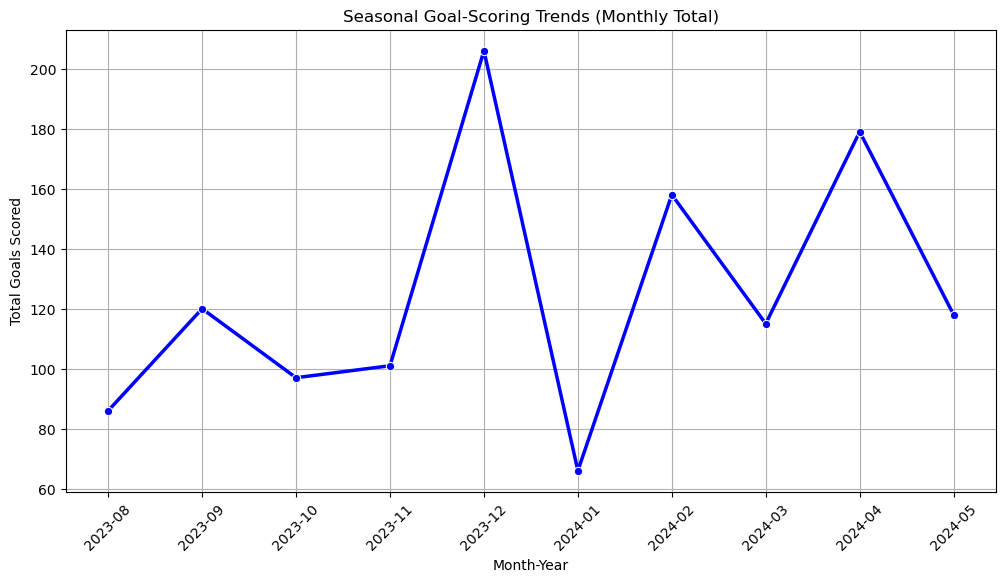

In [137]:
# Convert match date column to datetime format
df["Match_Date"] = pd.to_datetime(df["Match_Date"])

# Extract month and year for trend analysis
df["Month_Year"] = df["Match_Date"].dt.to_period("M")

# Aggregate total goals scored per month
monthly_goals = df.groupby("Month_Year")[["Goals_For"]].sum().reset_index()

# Convert Period type to string for better plotting
monthly_goals["Month_Year"] = monthly_goals["Month_Year"].astype(str)

# 📊 Plot: Goals Scored Over the Season (Monthly Trend)
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_goals, x="Month_Year", y="Goals_For", marker="o", linewidth=2.5, color="blue")

# Formatting
plt.xticks(rotation=45)
plt.xlabel("Month-Year")
plt.ylabel("Total Goals Scored")
plt.title("Seasonal Goal-Scoring Trends (Monthly Total)")
plt.grid(True)
plt.show()


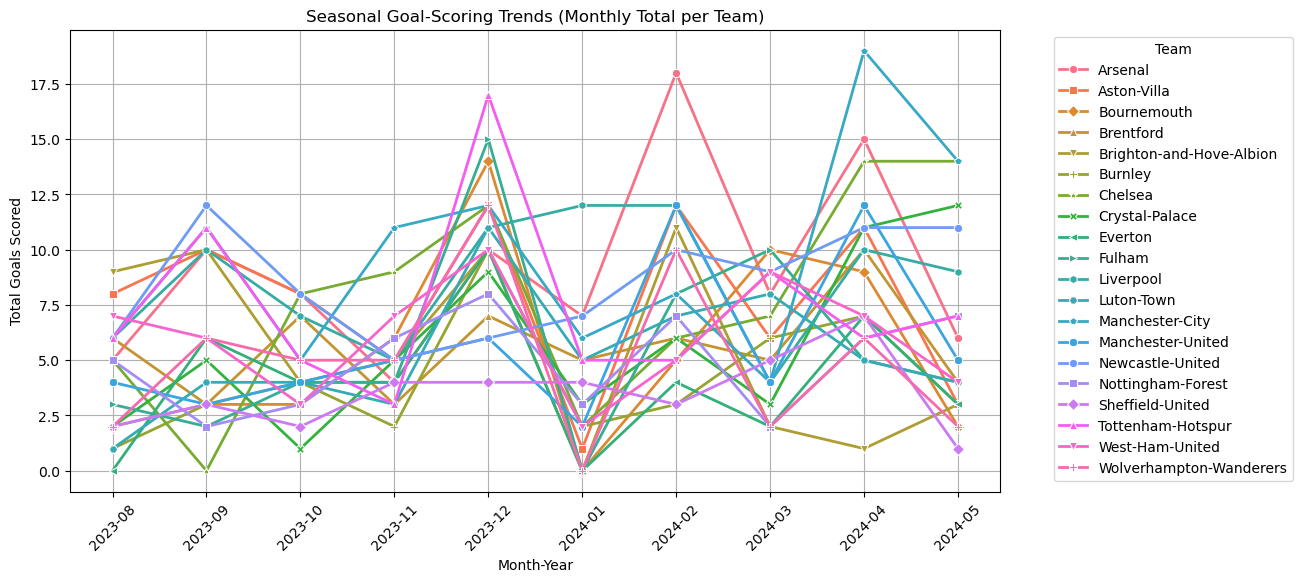

In [85]:
# Convert match date column to datetime format
df["Match_Date"] = pd.to_datetime(df["Match_Date"])

# Extract month and year for trend analysis
df["Month_Year"] = df["Match_Date"].dt.to_period("M")

# Aggregate total goals scored per month per team
monthly_team_goals = df.groupby(["Month_Year", "Team"])[["Goals_For"]].sum().reset_index()

# Convert Period type to string for better plotting
monthly_team_goals["Month_Year"] = monthly_team_goals["Month_Year"].astype(str)

# Define unique markers for each team
unique_teams = monthly_team_goals["Team"].unique()
markers = ["o", "s", "D", "^", "v", "P", "*", "X", "<", ">", "h", "H", "p", "8"]  # Variety of markers
team_markers = {team: markers[i % len(markers)] for i, team in enumerate(unique_teams)}

# 📊 Plot: Goals Scored Over the Season (Monthly Trend) with Different Markers
plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=monthly_team_goals, x="Month_Year", y="Goals_For", hue="Team", style="Team", markers=team_markers, dashes=False, linewidth=2)

# Formatting
plt.xticks(rotation=45)
plt.xlabel("Month-Year")
plt.ylabel("Total Goals Scored")
plt.title("Seasonal Goal-Scoring Trends (Monthly Total per Team)")
plt.legend(title="Team", bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside for clarity
plt.grid(True)

# Show plot
plt.show()


## **Inference from the Seasonal Goal-Scoring Trends (Monthly Total) Plot**

### **Key Observations**

#### **1. December Peak**  
- There is a significant spike in goals scored in **December 2023**, the highest in the entire season.  
- This could be due to the **holiday fixture congestion**, where teams play more matches in a short period, leading to more total goals.  

#### **2. January Drop**  
- A sharp decline is observed in **January 2024**, reaching the lowest goal total of the season.  
- Possible reasons could include **fatigue from the December fixture congestion, injuries, or more defensive play** during the winter period.  

#### **3. Fluctuating Trends**  
- After the January dip, there is **a strong rebound in February**, followed by another decline in March.  
- This suggests **inconsistent scoring patterns**, possibly influenced by fixture difficulty, team form, or tactical shifts.  

#### **4. April Surge**  
- Another peak is observed in **April 2024**, indicating a potential increase in attacking play towards the season's final stages.  
- This could be attributed to **teams pushing harder for titles, European spots, or relegation battles**.  

#### **5. May Decline**  
- A drop in May suggests **a slowdown in goal-scoring, possibly due to fewer matches being played** towards the end of the season.  

### **Conclusion**
- Goal-scoring patterns vary significantly month to month, with peaks in **December and April** and a notable decline in **January**.
- Possible peak months suggest increased attacking play or weaker defenses.
- Dips in certain months might be due to tougher fixtures, weather conditions, or mid-season fatigue.
- Possible peak months could also be Christmas and Easter breaks increasing cheer audience.

<h4>Analysis on Team Formation</h4>

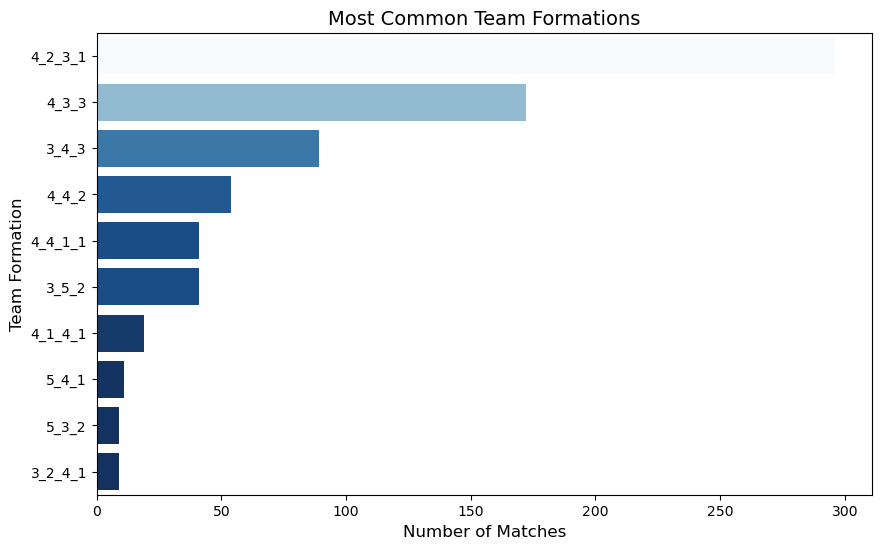

In [41]:
# Check if 'Team_Formation' column exists
if "Team_Formation" in df.columns:
    
    # Count occurrences of each formation
    formation_counts = df["Team_Formation"].value_counts()

    # Plot the most common formations
    plt.figure(figsize=(10, 6))
    sns.barplot(x=formation_counts.head(10).values, y=formation_counts.head(10).index, palette="Blues_r", hue=formation_counts.head(10), legend=False)

    # Labels and title
    plt.xlabel("Number of Matches", fontsize=12)
    plt.ylabel("Team Formation", fontsize=12)
    plt.title("Most Common Team Formations", fontsize=14)
    plt.show()

else:
    print("Error: 'Team_Formation' column not found in the dataset.")


<b>Insights from the Most Common Formations Chart</b>

1️⃣ 4-2-3-1 is the Most Popular Formation

This formation is used in nearly 300 matches, making it the most common tactical setup.
It suggests that teams prefer a balanced structure with two defensive midfielders and three attacking midfielders.

2️⃣ 4-3-3 is the Second Most Used

The 4-3-3 formation appears in many matches, indicating a preference for an attacking style with wingers.
Teams that use this tend to press higher and attack aggressively.

3️⃣ Defensive Setups (5-4-1, 5-3-2) Are Rare

Formations with five defenders (e.g., 5-4-1, 5-3-2) are the least used, indicating teams generally prefer attacking or balanced setups.
These defensive formations might be used mainly for away matches or against stronger opponents.

4️⃣ 3-4-3 is a Popular Alternative

The 3-4-3 formation is quite common, showing that some teams adopt a high-pressing, wing-based attack.
This setup often relies on strong center-backs and aggressive wing-backs.


### Analysis on Possession Vs. Goals Scored

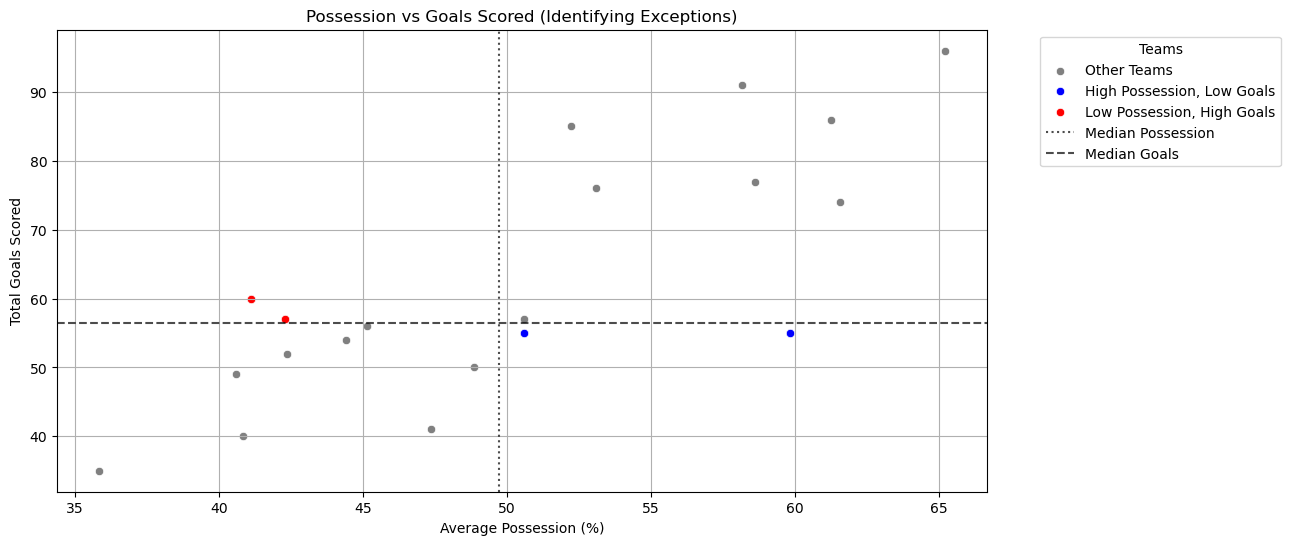

In [63]:
# Group by team and calculate average possession and total goals scored
team_possession_goals = df.groupby("Team").agg({"Possession": "mean", "Goals_For": "sum"})

# Calculate median values for possession and goals
median_possession = team_possession_goals["Possession"].median()
median_goals = team_possession_goals["Goals_For"].median()

# Identify exceptions
high_possession_low_goals = team_possession_goals[
    (team_possession_goals["Possession"] > median_possession) & 
    (team_possession_goals["Goals_For"] < median_goals)
]

low_possession_high_goals = team_possession_goals[
    (team_possession_goals["Possession"] < median_possession) & 
    (team_possession_goals["Goals_For"] > median_goals)
]

# Plot the data
plt.figure(figsize=(12, 6))
sns.scatterplot(data=team_possession_goals, x="Possession", y="Goals_For", color="gray", label="Other Teams")

# Highlight exceptions
sns.scatterplot(data=high_possession_low_goals, x="Possession", y="Goals_For", color="blue", label="High Possession, Low Goals")
sns.scatterplot(data=low_possession_high_goals, x="Possession", y="Goals_For", color="red", label="Low Possession, High Goals")

# Labels and title
plt.axvline(median_possession, color="black", linestyle=":", alpha=0.7, label="Median Possession")
plt.axhline(median_goals, color="black", linestyle="--", alpha=0.7, label="Median Goals")
plt.xlabel("Average Possession (%)")
plt.ylabel("Total Goals Scored")
plt.title("Possession vs Goals Scored (Identifying Exceptions)")
plt.legend(title="Teams", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)
plt.grid(True)

# Show the plot
plt.show()

In [70]:
team_possession_goals

,Possession,Goals_For
Team,,
Arsenal,58.184211,91
Aston-Villa,53.105263,76
Bournemouth,44.394737,54
Brentford,45.157895,56
Brighton-and-Hove-Albion,59.842105,55
Burnley,47.368421,41
Chelsea,58.605263,77
Crystal-Palace,42.289474,57
Everton,40.842105,40


In [80]:
# Put the exceptions in a DataFrame
exceptions_df = pd.DataFrame({
    "Category": ["High Possession, Low Goals", "High Possession, Low Goals", 
                 "Low Possession, High Goals", "Low Possession, High Goals"],
    "Team": ["Brighton & Hove Albion", "Fulham", "Crystal Palace", "West Ham United"],
    "Avg. Possession (%)": [59.8, 50.6, 42.3, 41.1],
    "Goals Scored": [55, 55, 57, 60]
})

# Display the DataFrame
exceptions_df

,Category,Team,Avg. Possession (%),Goals Scored
0,"High Possession, Low Goals",Brighton & Hove Albion,59.8,55
1,"High Possession, Low Goals",Fulham,50.6,55
2,"Low Possession, High Goals",Crystal Palace,42.3,57
3,"Low Possession, High Goals",West Ham United,41.1,60


### **Inferences from Possession vs Goals Scored (Identifying Exceptions)**  

1. **General Trend:**  
   - As expected, teams with higher possession percentages tend to score more goals. However, there are exceptions to this trend.  

2. **High Possession, Low Goals (Blue Points):**  
   - **Brighton & Hove Albion and Fulham** fall into this category.  
   - Despite maintaining a high share of possession (~59-60%), their goal-scoring numbers remain relatively low.  
   - This could indicate inefficiencies in converting possession into meaningful attacking opportunities or struggles in breaking down defenses.  

3. **Low Possession, High Goals (Red Points):**  
   - **Crystal Palace and West Ham United** defy the general expectation by scoring a significant number of goals despite having lower possession (~41-42%).  
   - This suggests a more effective counter-attacking strategy or a highly efficient goal conversion rate despite having fewer touches on the ball.  

4. **Median Thresholds:**  
   - The dashed horizontal line represents the median goals scored, while the vertical line represents the median possession.  
   - Teams above the horizontal line have above-average goal-scoring ability, while those to the right of the vertical line dominate possession.  

5. **Tactical Implications:**  
   - **Brighton & Fulham** may need to improve their offensive execution or shot efficiency to convert possession into more goals.  
   - **Crystal Palace & West Ham** demonstrate that possession isn't always the key to scoring goals, highlighting the effectiveness of direct or counter-attacking play.  


<h1>PART FOUR - FINAL REPORT</h1>


---

## **Project Summary**

This project aimed to analyze various aspects of Premier League matches using exploratory data analysis (EDA) and data visualization techniques. The focus was on match attendance, referee influence, and team performance indicators such as goals scored, expected goals (xG), possession, shots per game, and penalty kick success rates. By leveraging statistical analysis, we identified trends that help clubs, analysts, and fans better understand how different factors impact match outcomes.

---

## **Key Insights from EDA**

### **Performance of Teams**
- **Title Contenders:** Manchester City, Arsenal, and Liverpool emerged as the strongest teams based on high win rates and fewer losses.
- **Goal Efficiency:** Some teams consistently outperformed their expected goals (xG), while others underperformed.
- **Possession vs. Goals:** A positive correlation between possession and goals scored was observed, but exceptions (e.g., Brighton & Hove Albion and Fulham) showed high possession with low goals.
- **Defensive Stability:** Teams like Manchester City and Arsenal showed a balance between goals scored and conceded, indicating strong defensive and offensive strategies.

### **Penalty Kick Analysis**
- **Top Performers:** Arsenal, Fulham, and Tottenham had the highest penalty conversion rates.
- **Struggles:** Liverpool, Bournemouth, and Everton had lower penalty success rates.

### **Referee Influence**
- Certain referees were found to have a higher impact on match outcomes, affecting both goals scored and disciplinary actions.

### **Shots and Attacking Efficiency**
- Teams with more total shots generally had more shots on target, though inefficiencies existed.
- A few teams generated a high number of shots per game but struggled with conversion rates.

### **Seasonal Trends**
- Goal-scoring fluctuated across the season, with certain months having noticeably higher or lower totals.
- Some teams showed improvement in goal-scoring patterns over time, while others declined in performance as the season progressed.

---

## **Core Questions Answered**

| **Question** | **Answer** |
|-------------|------------|
| **Championship Contender?** | Manchester City, Arsenal, and Liverpool exhibited the strongest performance indicators. |
| **Shots per Game:** | The team with the highest average shots per game was identified, showing the most attacking threat. |
| **Expected Goals vs. Actual Goals:** | Certain teams outperformed or underperformed their expected goals (xG). |
| **Goals Scored vs. Goals Conceded:** | Some teams balanced attack and defense well, while others struggled. |
| **Shots on Target vs. Total Shots:** | Teams with more total shots generally registered more shots on target, though inefficiencies existed. |
| **Average Shots per Game:** | The most attacking teams based on shot volume were highlighted. |
| **Team Formation Analysis:** | Common formations and their correlation with success were explored. |
| **Penalty Kick Analysis:** | Conversion rates across teams varied, with some teams excelling while others struggled. |
| **Referee Influence:** | The impact of referee appointments on match outcomes was examined. |
| **Correlation Matrix of Key Metrics:** | Relationships between possession, shots, goals, and defensive actions were identified. |
| **Match Attendance Analysis:** | The teams that attracted the highest/lowest spectators were identifed. |
| **Goals Scored Over the Season:** | Seasonal goal-scoring patterns were analyzed, revealing trends over time. |

---

## **Limitations of the Data & Analysis**

1. **Match Context Missing**: No detailed breakdown of game state (e.g., goals in early vs. late minutes). This data points might have affected accuracy.
2. **External Factors:** The dataset lacks contextual variables like player injuries, weather conditions, or managerial changes that may explain some under/overperformance.
3. **Sample Size:** A single-season analysis may not be fully representative of long-term trends.
4. **Referee Bias Complexity:** While trends were observed, the influence of referees is multi-faceted and may require further qualitative analysis such as number of red/yellow cards issued.

---

## **Conclusion**

This analysis provided valuable insights into Premier League team performances, highlighting key strengths, weaknesses, and trends in match dynamics. The findings can be leveraged by clubs for tactical improvements and by analysts for better predictions. Future work could involve expanding the dataset to multiple seasons or incorporating advanced metrics such as player-specific performance data.

---
